# Exploratory Data Analysis

Разведочный анализ данных, визуализации, статистические исследования

Что можно сделать или проверить?

- Построить диаграммы рассеивания для параметров: лайки, кол-во медиаконтента, просмотры, комментарии

- Посмотреть корреляции между величинами

- Посчитать базовые описательные статистики: количество, средние 

- Кто написал максимальное количество статей?

- У кого самые популярные статьи? Критерии оценки: кол-во комментариев, просмотров, лайков.

- Посмотреть на описательные статистики по дням недели или по неделям

- Построить распределение длины постов: Кол-во постов в % от длины символов

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

import math

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib_venn
import seaborn as sns

import json
import yaml
import ast

import requests
from PIL import Image
from io import BytesIO
import IPython.display as Disp

from re import findall, match, sub
import itertools

from datetime import datetime
from datetime import tzinfo

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [2]:
PATH = "/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/"

https://stackoverflow.com/questions/18982584/inconsistency-in-saving-and-loading-pandas-dataframe-with-lists-as-values

In [479]:
df = pd.read_pickle(PATH + 'Full_analysis/Clustered_weaboo_data_02_05.pkl')
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,Лонгрид
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,Статья
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,Подборка
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,Подборка
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,Лонгрид


In [ ]:
# pandas_profiling.ProfileReport(df)

In [ ]:
def fancy_pie_chart(srs: pd.Series, title: str, path: str, donut_hole=0.3, labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
              'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']):
    """Function for plotting pie_chart (matplotlib) with custom settings.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    title : str
        Title for piechart.
        
    path : str, 
        Path for saving image.
        
    donut_hole : float, default=0.3
        Size of hole in center of chart.
    
    labels : list, default=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
              'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
        List of values for displaying on chart.

    Returns
    -------
        None. Printing pie_chart.
    
    """

    def func(pct, allvals):
        absolute = round(pct/100.*np.sum(allvals))
        return "{:.1f}%\n{:d} comments".format(pct, absolute)

    fig=plt.figure(figsize=(14,10))
    gs1 = gridspec.GridSpec(1,1,
        left=0.1,right=0.7,
        bottom=0.1,top=0.7,
    )

    pie_ax=fig.add_subplot(gs1[0])

    labels = labels # tmp.author_type.values  
    zero_list = [0]
    
    # Create a pie chart
    wedges = pie_ax.pie(
        srs,
        shadow=False,
        startangle=45, #frame=True, 
        autopct=lambda pct: func(pct, srs), 
        explode=zero_list + [0.05] * (len(labels) - 1)
    )

    bbox_props = dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

    for i, p in enumerate(wedges[0]):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle, "color":'k'})
        pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)


    centre_circle = plt.Circle((0,0), donut_hole, color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(title, fontsize=22, pad=20)
    plt.axis('equal')
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    pass

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def top_bar_plotting(dataframe: pd.DataFrame, values: pd.Series, path: str, 
                     colormap: str, title: str, ylabel: str, xlabel: str):
    """Function for plotting barchart (seaborn) with some colormap.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Dataframe for which the barplot is plotted. Must include author_name and author_avatar_url.
        
    values : pd.Series
        Data for barchart.
        
    path : str
        Path for saving image.
        
    colormap : str
        Used colormap. See matplotlib list of colormaps.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    my_cmap = plt.get_cmap(colormap)
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    labels = dataframe.author_avatar_url[::-1]
    values = values[::-1] 

    height = 0.9
    plt.barh(y=dataframe.author_name[::-1], width=values, height=height, 
             color=my_cmap(rescale(values)), 
             align='center')

    cntr = []
    for i, (label, value) in enumerate(zip(labels, values)):
        cntr.append(value)
    
    pic_wide = math.ceil(max(cntr) * 0.05)
    pic_indent = math.ceil(max(cntr) * 0.002)
    
    for i, (label, value) in enumerate(zip(labels, values)):
        im = Image.open(requests.get(label, stream=True).raw)
        plt.imshow(im, extent=[value - pic_wide, value - pic_indent, 
                               i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
        plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')


    plt.xlim(0, max(values) * 1.05)
    plt.ylim(-0.5, len(labels) - 0.5)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=22, pad=20)
    plt.tight_layout()

    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # END OF FUNC
    pass

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, path: str, xlim: int, ci_wide=90, desc_stat='mean', bins='auto'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True, bins=bins)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)
    ax.set_xlim(left=-10, right=xlim)

    plt.tight_layout()
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # END OF FUNC
    pass

In [ ]:
df.groupby(['is_repost']).agg({'id': "count"})

In [ ]:
df.groupby(['is_repost']).agg({'id': "count"})['id']

In [ ]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'id': "count"})
tmp

In [ ]:
def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['id'],
    shadow=False,
    colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['id']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
                             "color":colors[i]
#                              "color":'b'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество постов', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
sns.set_theme()

In [ ]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'comments_count': "sum"})
tmp

In [ ]:
tmp.comments_count.sum()

In [ ]:
sns.set_palette("tab10")

In [ ]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} comments".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['comments_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['comments_count']), 
    explode=[0, 0.05, 0.05, 0.05]
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.3, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество комментариев у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/comments.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
sns.set_palette("husl", 8)
fancy_pie_chart(tmp.comments_count, 'Общее количество комментариев у публикаций', 'test_1.jpg', donut_hole=0.9)

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="comments_count", 
                   data=df, join=False, capsize=.1, palette="Set2")

plt.title('Сравнение среднего количества комментариев в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество комментариев')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/comments_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['is_repost']).agg({'comments_count': ['mean', 'std']})

In [ ]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'hits_count': "sum"})
tmp

In [ ]:
tmp.hits_count.sum()

In [ ]:
sns.set_palette("husl", 2)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} просмотров".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nПросмотры',  
          'Репост \nПросмотры', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['hits_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['hits_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.25, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество просмотров у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/hits.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
labels = ['Пост подсайта \nПросмотры',  
          'Репост \nПросмотры', ]
fancy_pie_chart(tmp.hits_count, donut_hole=0.3, labels=labels)

In [ ]:
# sns.boxplot(x="is_repost", y="hits_count", data=df)

In [ ]:
df.columns

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="hits_count", 
                   data=df, join=False, capsize=.1, palette="Set2")

plt.title('Сравнение среднего количества просмотров \nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество просмотров')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/hits_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['is_repost']).agg({'hits_count': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'favorites_count': "sum"})
tmp

In [ ]:
tmp.favorites_count.sum()

KeyError: 'favorites_count'

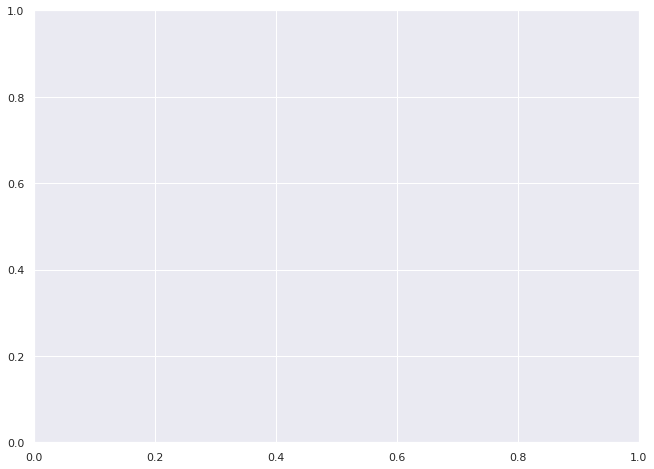

In [65]:
sns.set_palette("hls", 4)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} ДвЗ".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nДобавлений в закладки',  
          'Репост \nДобавлений в закладки', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['favorites_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['favorites_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество добавлений в закладки у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/favs.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'favorites_count': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="favorites_count", 
                   data=df, join=False, capsize=.1, palette="hls")

plt.title('Сравнение среднего количества добавлений в закладки поста\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество ДвЗ')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/favs_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'likes': "sum"})
tmp

In [ ]:
tmp.likes.sum()

In [ ]:
sns.set_palette("icefire_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} likes".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['likes'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['likes']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество лайков у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="likes", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества лайков у поста\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество лайков')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/likes_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['is_repost']).agg({'likes': ['mean', 'std']})

In [ ]:
tmp_symbols = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'symbols': "sum"})
tmp_symbols

In [ ]:
tmp_symbols.symbols.sum()

In [ ]:
sns.set_palette("husl")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} символов".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_symbols['symbols'],
    shadow=False,
#     colors=colors, 
    startangle=135, #frame=True, 
    autopct=lambda pct: func(pct, tmp_symbols['symbols']), 
    explode=(0, 0.05, 0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.89, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество символов в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/symbols.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'symbols': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="symbols", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества символов в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество символов')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/symbols_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# total = sum(tmp_symbols.symbols)
# proportions = [(float(value) / total) for value in tmp_symbols.symbols]

In [ ]:
# width = 40
# height=10
# total= width * height
# tiles_per_category = [round(proportion * total) for proportion in proportions]

In [ ]:
# waffle = np.zeros((height, width))
# category_index = 0
# tile_index = 0

# for col in range(width):
#     for row in range(height):
#         tile_index += 1
#         if tile_index > sum(tiles_per_category[0:category_index]):
#             category_index += 1
#         waffle[row, col] = category_index

# # fig = plt.figure()
# # colormap = plt.cm.coolwarm
# # plt.matshow(waffle, cmap=colormap)
# # plt.colorbar()

# fig = plt.figure()
# colormap = plt.cm.coolwarm
# plt.matshow(waffle, cmap=colormap)
# ax = plt.gca()
# ax.set_xticks(np.arange(-0.5, (width), 1), minor=True)
# ax.set_yticks(np.arange(-0.5, (height), 1), minor=True)
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
# plt.xticks([])
# plt.yticks([])
# plt.colorbar()

https://github.com/laserson/squarify#Documentation-for-Squarify

https://pypi.org/project/pywaffle/

https://pypi.org/project/squarify/#history

https://plotly.com/python/treemaps/

https://towardsdatascience.com/treemap-basics-with-python-777e5ed173d0

https://towardsdatascience.com/creating-compelling-pie-chart-alternatives-3a1c2c2889b8

https://stackoverflow.com/questions/3282935/treemap-visualization-in-python

https://towardsdatascience.com/waffle-charts-using-pythons-matplotlib-94252689a701

In [ ]:
tmp_symbols

In [ ]:
from pywaffle import Waffle

labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
d = {lab: val for lab, val in zip(labels, tmp_symbols.symbols.values)}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=9, 
    values=list(tmp_symbols.symbols/9500),
#     labels=labels,
    title={
        'label': 'Количество символов в публикациях',
        'loc': 'center',
        'fontdict': {
            'fontsize': 20
        }
    },
#     labels=[f"{k} ({int(v / sum(d.values()) * 100)}%)" for k, v in d.items()],
    legend={
        'labels': [f"{k} ({v} единиц, {round(v/sum(d.values())*100,2)}%)" for k, v in d.items()],  # labels could also be under legend instead
        'loc': 'lower left',
        'bbox_to_anchor': (0.02, -0.2),
        'ncol': len(labels),
        'framealpha': 0,
        'fontsize': 12
    },
    figsize=(22, 8),
#     legend={'bbox_to_anchor': (1.3, 0.85)}    
)
# plt.savefig(PATH + "Full_analysis/symbols_waffle.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sum(d.values())

In [ ]:
tmp_media = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'total_mediacontent': "sum"})
tmp_media

In [ ]:
sns.set_palette("viridis_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} medias".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_media['total_mediacontent'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp_media['total_mediacontent']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.88, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество единиц медиконтента в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/medias.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['is_repost']).agg({'total_mediacontent': ['mean', 'std']})

In [ ]:
plt.rcParams["figure.figsize"] = [8, 10]
ax = sns.pointplot(x="is_repost", y="total_mediacontent", 
                   data=df, join=False, capsize=.1, palette="husl")

plt.title('Сравнение среднего количества медиаконтента в посте\nв зависимости от происхождения публикации', fontsize=22, pad=20)
plt.ylabel('Среднее количество медиаконтента')
plt.xlabel('Статья - это репост?')

# plt.savefig(PATH + "Full_analysis/medias_compare.jpg", dpi=300, bbox_inches='tight')

In [ ]:
tmp_media

In [ ]:
tmp_media.total_mediacontent.sum()

In [ ]:
from pywaffle import Waffle

labels=['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']
d = {lab: val for lab, val in zip(labels, tmp_media.total_mediacontent.values)}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=12, 
    values=list(tmp_media.total_mediacontent/69.5),
#     labels=labels,
    title={
        'label': 'Количество медиаконтента в публикациях',
        'loc': 'center',
        'fontdict': {
            'fontsize': 20
        }
    },
#     labels=[f"{k} ({int(v / sum(d.values()) * 100)}%)" for k, v in d.items()],
    legend={
        'labels': [f"{k} ({v} единиц, {round(v/sum(d.values())*100,2)}%)" for k, v in d.items()],  # labels could also be under legend instead
        'loc': 'lower left',
        'bbox_to_anchor': (0.06, -0.2),
        'ncol': len(labels),
        'framealpha': 0,
        'fontsize': 12
    },
    figsize=(22, 8),
#     legend={'bbox_to_anchor': (1.3, 0.85)}    
)
# plt.savefig(PATH + "Full_analysis/media_waffle.jpg", dpi=300, bbox_inches='tight')

In [ ]:
print(len(df.author_name.unique()))
print(len(df[df.is_repost == False].author_name.unique()))
print(len(df[df.is_repost == True].author_name.unique()))

In [ ]:
author_set_post = set(df[df.is_repost == False].author_name.unique())
author_set_repost = set(df[df.is_repost == True].author_name.unique())

#### Venn diagram

https://pypi.org/project/matplotlib-venn/
    
https://stackoverflow.com/questions/55622820/python-venn-diagram-actual-label

https://stackoverflow.com/questions/55717203/plot-actual-set-items-in-python-not-the-number-of-items/55718006#55718006

https://stackoverflow.com/questions/42855256/python-venn-diagram-how-to-show-the-diagram-contents

https://stackoverflow.com/questions/46224235/matplotlib-venn-diagram-with-legend

https://stackoverflow.com/questions/51052573/matplotlib-venn-changing-what-is-displayed-inside-the-venn-diagram

https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram

In [ ]:
# Plotting Venn diagramm
from matplotlib_venn import venn2
plt.figure(figsize=(14,8))

venn = venn2([author_set_post, author_set_repost], ('Авторы подсайта', 'Авторы репостов'))

# venn.get_label_by_id('100').set_text('\n'.join(map(str, author_set_post-author_set_repost)))
# venn.get_label_by_id('110').set_text('\n'.join(map(str, author_set_post&author_set_repost)))
# venn.get_label_by_id('010').set_text('\n'.join(map(str, author_set_repost-author_set_post)))

plt.title('Количество уникальных авторов', fontsize=22)

# plt.savefig(PATH + "Full_analysis/authors_venn.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# feature_cols = ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols', 'words', 
#                 'images', 'videos', 'links', 'audio', 'total_mediacontent']

In [ ]:
# fig, axs = plt.subplots(ncols = 3,nrows = 1, figsize = (36,8.5))
# for i,j in enumerate(feature_cols[0:3]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes', ascending = False)[j],
#                 palette = "mako")
# fig.suptitle("likes", fontsize=30)

# fig, axs = plt.subplots(ncols = 8,nrows = 1, figsize = (36,5))
# for i,j in enumerate(feature_cols[3:11]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes',ascending = False)[j],
#                 palette = "mako")

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]
sns.set_theme()
sns.color_palette()

In [ ]:
# sns.scatterplot(x=df.symbols, size=df.likes, hue='is_repost', 
#                 y=sum([df.images, df.videos, df.links]), data=df)

# Разбираемся с построением столбчатых диаграмм

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/40066089/apply-images-to-pyplot-python-bar-graphs

# СУПЕР_ВАЖНО!

```python
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

labels = ['CW', 'CV', 'GW', 'SX', 'DO']
colors = ['crimson', 'dodgerblue', 'teal', 'limegreen', 'gold']
values = 30 + np.random.randint(5, 20, len(labels)).cumsum()

height = 0.9
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    # with cbook.get_sample_data('ada.png') as image_file:
    #    img = plt.imread(image_file)
    response = requests.get(f'https://www.countryflags.io/{label}/flat/64.png')
    img = plt.imread(BytesIO(response.content))
    plt.imshow(img, extent=[value - 8, value - 2, i - height / 2, i + height / 2], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()
```

# МЕГА-ВАЖНО!

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python

In [ ]:
# Первый, неудачный вариант

# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp.index[:5]
# colors = ['tan', 'peru', 'grey', 'orchid', 'darkred']
# values = tmp.values.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp.index[:5], width=tmp.values.flatten()[:5], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index

### Tests

In [ ]:
# tmp_2 = df.groupby(['author_name','author_avatar_url'], as_index=False).count() \
# .sort_values(by="id", ascending=False).head(20).iloc[:, [0,1,3]]
# tmp_2

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)

# plt.style.use('seaborn')    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

In [ ]:
# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# f = sns.barplot(y=tmp_2.author_name[:5][::-1], x=tmp_2.id[:5][::-1])
# ax = f

# for p in ax.patches:
#     width = p.get_width()    # get bar length
#     ax.text(width + 1,       # set the text at 1 unit right of the bar
#             p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#             '{:1.0f}'.format(width), # set variable to display, 2 decimals
#             ha = 'left',   # horizontal alignment
#             va = 'center')  # vertical alignment

# # for i, (label, value) in enumerate(zip(labels, values)):
# #     im = Image.open(requests.get(label, stream=True).raw)
# #     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# # plt.xlim(0, max(values) * 1.05)
# # plt.ylim(-0.5, len(labels) - 0.5)
# # plt.tight_layout()
# # plt.show()

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] 

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
#     plt.text(value + 3, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn

https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart

### Tests end
# Конец тестовой зоны

# Смотрим на топы по различным признакам

In [ ]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(20)
tmp

In [ ]:
df["date_alter"] = df.date.dt.date

In [ ]:
df.head()

In [ ]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(50)
tmp.index

In [ ]:
test = df.groupby(['date_alter', 'author_name']).agg({"id": "count"})
test

In [ ]:
test.index.get_level_values(0)

In [ ]:
test.pivot_table(values='id', index=test.index.get_level_values(0), columns='author_name').cumsum()

In [ ]:
test_v2 = test.pivot_table(values='id', index=test.index.get_level_values(0), columns='author_name').cumsum()

In [ ]:
test_v2.fillna(method='ffill', inplace=True)

In [ ]:
test_v2.iloc[0, :].fillna(0, inplace=True)

In [ ]:
test_v2.fillna(method='ffill', inplace=True)

In [ ]:
test_v2.isna().sum().unique()

In [ ]:
test_v2.index = pd.to_datetime(test_v2.index)

In [ ]:
test_v2.tail()

https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns

In [ ]:
test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'StupidMaronGuy', 'Тимур Лебедев',
       'Валера Чумаков', 'IcEWaRRiOr', 'Kits R', 'BioHazardAlBatros', 'Bsod',
       'Maks-arr', 'Hero', 'Мимо Проходил', 'Андрей Тор4']]
# test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
#        'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
#        'Хасаги', 'Koda', 'Over9k5000']]

test_v3 = test_v2[['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'Тимур Лебедев']]

In [ ]:
test_v3.shape

In [ ]:
test_v3.to_csv(PATH + 'test.csv')

In [ ]:
test_v3.loc['2021-05-02']

In [ ]:
plt.rcParams["figure.figsize"] = [14, 20]

In [ ]:
s = test_v3.loc['2021-01-25']

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 14), dpi=144)
colors = plt.cm.Dark2(range(6))
y = s.index
width = s.values
ax.barh(y=y, width=width, color=colors);

In [ ]:
def nice_axes(ax):
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=8, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]
    
nice_axes(ax)
fig

In [ ]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-08-27', '2020-08-28', '2020-08-29']
for ax, date in zip(ax_array, dates):
    s = test_v3.loc[date].sort_values()
    ax.barh(y=s.index, width=s.values, color=colors)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

In [ ]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-08-27', '2020-08-28', '2020-08-29']
for ax, date in zip(ax_array, dates):
    s = test_v3.loc[date]
    y = test_v3.loc[date].rank(method='first').values
    ax.barh(y=y, width=s.values, color=colors, tick_label=s.index)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

In [ ]:
df2 = test_v3.reset_index()
last_idx = df2.index[-1] + 1
df_expanded = df2.reindex(range(last_idx))
df_expanded = df_expanded.set_index('date_alter')
df_rank_expanded = df_expanded.rank(axis=1, method='first')

In [ ]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 20), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten()):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-08-29')
ax_array[-1].set_title('2020-08-30');

In [ ]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 2), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten(), start=5):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-03-30')
ax_array[-1].set_title('2020-03-31');

In [ ]:
from matplotlib.animation import FuncAnimation

def init():
    ax.clear()
    nice_axes(ax)

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%B %-d, %Y')
    ax.set_title(f'Количество публикаций пользователя - {date_str}', fontsize='smaller')
    ax.set_xlabel(f'Количество постов')
    ax.set_ylabel(f'Автор')
    ax.set_axisbelow(True)
    
fig = plt.Figure(figsize=(20, 9), dpi=144)
ax = fig.add_subplot()
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [ ]:
from IPython.display import HTML
html = anim.to_html5_video()
HTML(html)

In [ ]:
anim.save(PATH + 'posts_race.mp4')

https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096

# Alternative

https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41

In [ ]:
# test_v3.head()

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# def draw_barchart(date):
#     dff = df[df['year'].eq(year)].sort_values(by='value', ascending=True).tail(10)
#     ax.clear()
#     ax.barh(dff['name'], dff['value'], color=[colors[group_lk[x]] for x in dff['name']])
#     dx = dff['value'].max() / 200
#     for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
#         ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
#         ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
#         ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
#     # ... polished styles
#     ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
#     ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#     ax.xaxis.set_ticks_position('top')
#     ax.tick_params(axis='x', colors='#777777', labelsize=12)
#     ax.set_yticks([])
#     ax.margins(0, 0.01)
#     ax.grid(which='major', axis='x', linestyle='-')
#     ax.set_axisbelow(True)
#     ax.text(0, 1.12, 'The most populous cities in the world from 1500 to 2018',
#             transform=ax.transAxes, size=24, weight=600, ha='left')

#     plt.box(False)
    
# draw_barchart(2018)

# ALTERNATIVE

https://www.dexplo.org/bar_chart_race/

In [ ]:
import bar_chart_race as bcr

In [ ]:
test_v3.index

In [ ]:
test_v4 = test_v3[test_v3.index < '2020-08-15']
test_v4 = test_v4[test_v4.index > '2020-07-13']
test_v4.shape

Лучше рисовать это в Google Colab, меньше мороки. 

In [ ]:
bcr.bar_chart_race(
    df=test_v4,
    filename=PATH + 'bcr.mp4',
    orientation='h',
    sort='desc',
    n_bars=40,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=100,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Общее количество постов от пользователей: {v.nlargest(40).sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=100,
    figsize=(10, 6),
    dpi=144,
    cmap='dark12',
    title='Топ-40 авторов по количеству постов',
    title_size='',
    
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)  

In [ ]:
# bcr_html = bcr.bar_chart_race(df=test_v3, filename=None)

In [ ]:
new_test = df.groupby(['date_alter', 'author_name']).agg({"likes": "sum"})
new_test

In [ ]:
new_test.pivot_table(values='likes', index=new_test.index.get_level_values(0), columns='author_name').cumsum()

In [ ]:
new_test_v2 = new_test.pivot_table(values='likes', index=new_test.index.get_level_values(0), 
                               columns='author_name').cumsum()

In [ ]:
new_test_v2.fillna(method='ffill', inplace=True)

In [ ]:
new_test_v2.iloc[0, :].fillna(0, inplace=True)

In [ ]:
new_test_v2.fillna(method='ffill', inplace=True)

In [ ]:
new_test_v2.isna().sum().unique()

In [ ]:
new_test_v2.index = pd.to_datetime(new_test_v2.index)

In [ ]:
new_test_v2.tail()

In [ ]:
new_test_v3 = new_test_v2[['олег уходи',
 'Layben',
 'Гусь Хмурый',
 'Suzume-sama said OKawaii Koto',
 'Diego Paw',
 'Pray for Megumin',
 'Over9k5000',
 'mindtered',
 'Фанат Ани Тейлор-Джой',
 'Just Chill',
 'Хасаги',
 'Koda',
 'Алексей Кудрявцев',
 'Виабу',
 'Revendi',
 'deGoose',
 'Khornit',
 'Marshal_New_Arleana',
 'mora mora',
 'YuruCamp каждый день',
 'Kurisu Makise',
 'Люблю Пиццу',
 'Мимо Проходил',
 'Некстгенова Элой Плэйстэйшовна',
 'nahtigalka',
 'unheilig',
 'Zerescas',
 'Captain Galahard',
 'Bsod',
 'Анимемания',
 'Oleg Mattewho',
 'Wolandesu',
 'Jooo Laalll20467',
 'Андрей Тор4',
 'Mr. Piccolo',
 'СынМаэстро',
 'Asuka Soryu',
 'Михаил Тучинский',
 'StSpyro',
 'StupidMaronGuy']]

In [ ]:
new_test_v3.shape

In [ ]:
test_v3.shape

In [ ]:
new_test_v3.to_csv(PATH + 'rating.csv')

In [ ]:
tmp_posts = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False)
tmp_posts_1 = tmp_posts.iloc[0:20]
tmp_posts_2 = tmp_posts.iloc[20:40]

In [ ]:
print(tmp_posts.id.sum())
print('-----')
print(tmp_posts.iloc[0:3].id)
print('-----')
print(816 + 711 + 466)
print('-----')
print(tmp_posts.iloc[0:3].id.sum())

In [ ]:
70 / 440

In [ ]:
tmp_posts.iloc[0:15].id.sum() / tmp_posts.id.sum() * 100

In [ ]:
tmp_posts.iloc[0:70].id.sum() / tmp_posts.id.sum() * 100

In [ ]:
tmp_posts

In [ ]:
# tmp_posts.set_index('author_name').cumsum()

In [ ]:
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 35, value - 2, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def top_bar_plotting(dataframe: pd.DataFrame, values: pd.Series, path: str, 
                     colormap: str, title: str, ylabel: str, xlabel: str):
    """Function for plotting barchart (seaborn) with some colormap.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Dataframe for which the barplot is plotted. Must include author_name and author_avatar_url.
        
    values : pd.Series
        Data for barchart.
        
    path : str
        Path for saving image.
        
    colormap : str
        Used colormap. See matplotlib list of colormaps.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    my_cmap = plt.get_cmap(colormap)
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    labels = dataframe.author_avatar_url[::-1]
    values = values[::-1] 

    height = 0.9
    plt.barh(y=dataframe.author_name[::-1], width=values, height=height, 
             color=my_cmap(rescale(values)), 
             align='center')

    cntr = []
    for i, (label, value) in enumerate(zip(labels, values)):
        cntr.append(value)
    
    pic_wide = math.ceil(max(cntr) * 0.05)
    pic_indent = math.ceil(max(cntr) * 0.002)
    
    for i, (label, value) in enumerate(zip(labels, values)):
        im = Image.open(requests.get(label, stream=True).raw)
        plt.imshow(im, extent=[value - pic_wide, value - pic_indent, 
                               i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
        plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')


    plt.xlim(0, max(values) * 1.05)
    plt.ylim(-0.5, len(labels) - 0.5)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=22, pad=20)
    plt.tight_layout()

    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')

    plt.show()
    
    # END OF FUNC

In [ ]:
top_bar_plotting(tmp_posts_1, tmp_posts_1.id, 'test.jpg', 'coolwarm', 
                 'Топ-20 авторов по количеству публикаций', 'Авторы', 'Количество публикаций')

In [ ]:
my_cmap = plt.get_cmap("coolwarm_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_2.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_2.author_name[::-1], width=tmp_posts_2.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 3, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

Reposts counts

In [ ]:
tmp_posts_alter = df[df.is_repost == True].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False).head(40)
tmp_posts_1 = tmp_posts_alter.iloc[0:20]

In [ ]:
my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 5, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество репостнутых публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству репостов в подсайте', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_reposted.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
top_bar_plotting(tmp_posts_1, 'test.jpg', 'coolwarm_r')

In [ ]:
df.columns

# ---

In [66]:
tmp_likes = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({"likes": "sum"}).sort_values(by="likes", ascending=False).head(40)
tmp_likes_1 = tmp_likes.iloc[0:20]
tmp_likes_2 = tmp_likes.iloc[20:40]
tmp_likes.head(5)

,author_name,author_avatar_url,likes
337,олег уходи,https://leonardo.osnova.io/b6f745b6-3963-56d5-...,26556
93,Layben,https://leonardo.osnova.io/7fec5e46-2507-5dcd-...,16945
257,Гусь Хмурый,https://leonardo.osnova.io/8fd51f8a-d2eb-2130-...,13352
156,Suzume-sama said OKawaii Koto,https://leonardo.osnova.io/67548a81-f44f-5dc9-...,12489
42,Diego Paw,https://leonardo.osnova.io/7df667af-003c-502d-...,7362


In [ ]:
# top_bar_plotting(tmp_likes_1, tmp_likes_1.likes, 'test.jpg', 'magma')

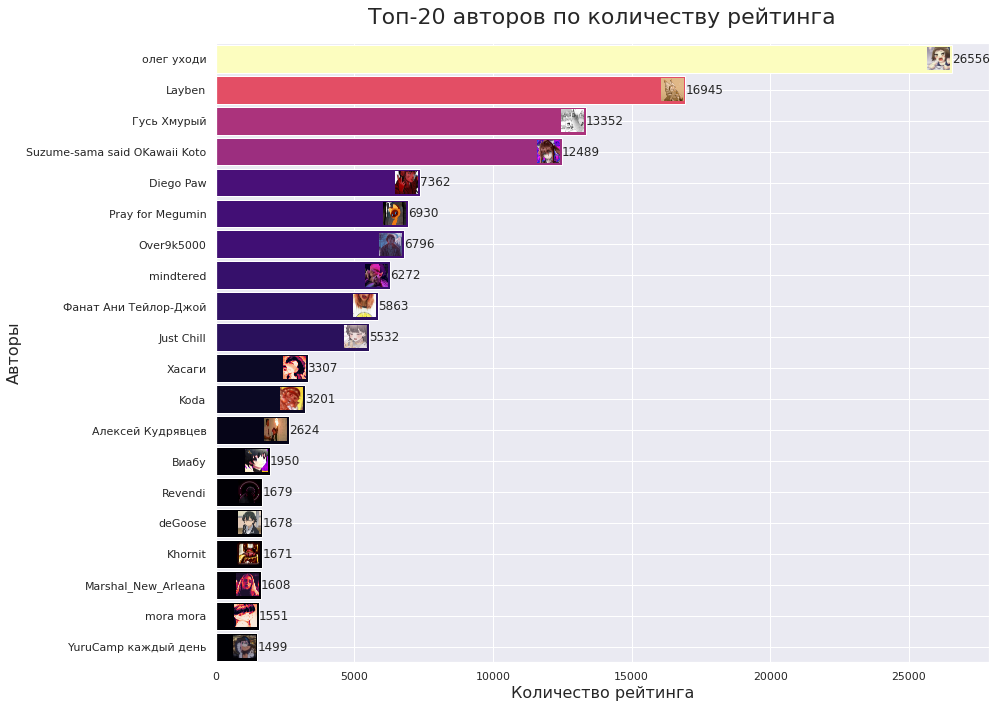

In [67]:
plt.rcParams["figure.figsize"] = [14, 10]
my_cmap = plt.get_cmap("magma")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_1.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_1.author_name[::-1], width=tmp_likes_1.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 900, value - 100, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_2.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_2.author_name[::-1], width=tmp_likes_2.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 55, value - 5, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
top_bar_plotting(tmp_likes_2, tmp_likes_2.likes, "test.jpg", 'magma_r')

# ---

# ---

In [ ]:
df.head()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, path: str, xlim: int, ci_wide=90, desc_stat='mean', bins='auto'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True, bins=bins)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)
    ax.set_xlim(left=-10, right=xlim)

    plt.tight_layout()
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    plt.show()
    
    pass
    # END OF FUNC

In [ ]:
df.columns

In [ ]:
# df.favorites_count.sort_values(ascending=False).head(20)

In [ ]:
plt.rcParams["figure.figsize"] = [14, 8]

sns.histplot(x = df.likes, data=df, kde=True, bins=70).set_title("Лайки")
# plt.savefig(PATH + "Full_analysis/simple_likes_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.histplot(x = df.likes, data=df, hue='is_repost', kde=True, bins=70).set_title("Лайки")

In [ ]:
histogram_plotting(df.likes, "simple_likes_CI_hist.jpg", 200, desc_stat='median', ci_wide=95, bins=80)
plt.show()

In [ ]:
sns.histplot(x = df.favorites_count, data=df, kde=True, color="r", 
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]).set_title("Добавления в закладки")
# plt.savefig(PATH + "Full_analysis/simple_fav_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.histplot(x = df.favorites_count, data=df, hue='is_repost', kde=True,
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]).set_title("Добавления в закладки")

In [ ]:
histogram_plotting(df.favorites_count, "simple_favs_CI_hist.jpg", 100, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

In [ ]:
sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
             bins=100).set_title("Комментарии")
# plt.savefig(PATH + "Full_analysis/simple_comm_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.comments_count, "simple_comm_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

In [ ]:
df.hits_count.sort_values(ascending=False)

In [ ]:
sns.histplot(x = df.hits_count, data=df, kde=True, color="#b29705", 
             bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")
# plt.savefig(PATH + "Full_analysis/simple_hits_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.hits_count, "simple_hits_CI_hist.jpg", 2000, desc_stat='median', 
                   ci_wide=95, bins=1000)
plt.show()

In [ ]:
sns.histplot(x = np.log(df.hits_count), data=df, kde=True, color="#b29705", 
#              bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")

In [ ]:
from matplotlib.colors import get_named_colors_mapping
get_named_colors_mapping()

In [ ]:
sns.histplot(x = df.symbols, data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
             bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")
# plt.savefig(PATH + "Full_analysis/simple_symb_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.symbols, "simple_symbols_CI_hist.jpg", 3000, desc_stat='median', 
                   ci_wide=95)
plt.show()

In [ ]:
sns.histplot(x = np.log(df.symbols +1), data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
#              bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")

In [ ]:
sns.histplot(x = df.total_mediacontent, data=df, kde=True, color="c", 
                bins=[0,5,10,20,30,40,50,100,150,200,250]
            ).set_title("Количество медиаконтента")
# plt.savefig(PATH + "Full_analysis/simple_media_hist.jpg", dpi=300, bbox_inches='tight')

In [ ]:
histogram_plotting(df.total_mediacontent, "simple_mc_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=[0,5,10,25,50,100])
plt.show()

In [ ]:
sns.histplot(x = np.log(df.total_mediacontent + 1), data=df, kde=True, color="c", 
#                 bins=[0,1,2,3,4,5]
            ).set_title("Количество медиаконтента")

In [ ]:
# plt.rcParams["figure.figsize"] = [16, 14]
# f, axes = plt.subplots(2, 3, )
# f.suptitle("Количественные характеристики публикаций")

# sns.histplot(x = df.likes, data=df, kde=True, ax=axes[0,0], bins=70).set_title("Лайки")
# sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
#              ax=axes[0,1], bins=100).set_title("Комментарии")
# sns.histplot(x = df.favorites_count, data=df, kde=True, color="#de0c62", 
#              bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000], ax=axes[0,2]) \
# .set_title("Добавления в закладки")

In [ ]:
df.columns

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
# df.likes[(df.is_repost == False) & (df.author_type == 2)]

In [ ]:
f, axes = plt.subplots(2, 2, )#sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[0,0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[1,0], bins=30).set_title("Репосты")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[0,1], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[1,1], bins=30).set_title("Репосты")

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[df.is_repost == False], 
             data=df, kde=True, ax=axes[0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[df.is_repost == True], 
             data=df, kde=True, ax=axes[1], bins=30).set_title("Репосты")

In [ ]:
sns.distplot(df.likes, kde=True, color="b")

In [ ]:
len('двенадцать')

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(14, 10))
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df.likes, kde=True, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(df.favorites_count, kde=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(df.hits_count, kde=True, color="g", kde_kws={"shade": True}, ax=axes[0, 2])

# Plot a histogram and kernel density estimate
sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[0, 3])

# sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[1, 0])

plt.setp(axes, yticks=[])
plt.tight_layout()

#### Корреляция

In [ ]:
df.columns

In [ ]:
sns.heatmap(df.loc[:, ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols',
                       'images', 'videos', 'links', 'audio', 'total_mediacontent']].corr(method='pearson'), 
            annot=True)

plt.title('Корреляционная матрица признаков', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/corr_matrix.jpg", dpi=300, bbox_inches='tight')

In [ ]:
pd.plotting.scatter_matrix(df[['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols',
                       'images', 'videos', 'links', 'audio', 'total_mediacontent']], alpha=1, figsize=(20,15));
# plt.savefig(PATH + "Full_analysis/corr_scatter.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# from scipy import stats

# cols = ['comments_count', 'favorites_count', 'hits_count', 'symbols',
#         'images', 'videos', 'links', 'audio', 'total_mediacontent']

# for col in cols: 
#     pearson_coef, p_value = stats.pearsonr(df[col], df['likes'])
#     print("PearsonR между {} и likes {} с P-значением P = {}".format(
#           col, pearson_coef, p_value ))
    
#     if p_value < 0.001:
#         print('Корреляция между {} и likes статистически значимая'.format(col))
#     elif p_value < 0.05:
#         print('Корреляция между {} и likes средняя'.format(col))
#     elif p_value < 0.1:
#         print('Корреляция между {} и likes слабая'.format(col))
#     else:
#         print('Корреляция между {} и likes статистически незначимая'.format(col))
        
#     if pearson_coef > 0 :
#         if pearson_coef > 0.85:
#             print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.75 :
#             print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.60:
#             print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.50 :
#             print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
#     else:
#         if abs(pearson_coef) > 0.85:
#             print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.75 :
#             print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.60:
#             print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.50 :
#             print('Коэффициент ~{} показывает негативную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает негативную слабую связь\n'.format(pearson_coef))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.total_mediacontent+1), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.total_mediacontent+1), y=np.log(df.likes+10))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.symbols+10), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.symbols+10), y=np.log(df.likes+10))

In [ ]:
sns.scatterplot(data=df, x='symbols', y='likes')
plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством символов и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_symbols.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.scatterplot(data=df, x='total_mediacontent', y='likes')
plt.xlabel('Количество медиаконтента в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_media.jpg", dpi=300, bbox_inches='tight')

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x='symbols', y='total_mediacontent', hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Количество медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x=np.log(df.symbols + 1), y=np.log(df.total_mediacontent + 1), hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Логарифм от количества символов в публикации', fontsize=16)
plt.ylabel('Логарифм от количества медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_log_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
sns.set()
ax = sns.scatterplot(x=np.log(df.words + 1), y=np.log(df.total_mediacontent + 1), hue='likes', 
                     palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Логарифм от количества слов в публикации', fontsize=16)
plt.ylabel('Логарифм от количества медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_log_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
df.groupby(['author_name']).agg({'id': 'count', 'likes': ['max', 'sum']}) \
    .sort_values(by=("id",'count'), ascending=False)

In [ ]:
df.groupby(['author_name', 'is_repost']).agg({'id': 'count', 'likes': ['max', 'sum']}).sort_values(by=("id",'count'), ascending=False)

https://stackoverflow.com/questions/62884183/trying-to-add-a-colorbar-to-a-seaborn-scatterplot

https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

https://stackoverflow.com/questions/33436221/displaying-rotatable-3d-plots-in-ipython-or-jupyter-notebook

https://matplotlib.org/2.2.5/gallery/mplot3d/rotate_axes3d.html

https://stackoverflow.com/questions/49981313/rotate-interactively-a-3d-plot-in-python-matplotlib-jupyter-notebook

https://stackoverflow.com/questions/14261903/how-can-i-open-the-interactive-matplotlib-window-in-ipython-notebook

https://stackoverflow.com/questions/38326983/how-to-rotate-a-3d-surface-in-matplotlib

https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

In [ ]:
# %matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [12, 16]

x,y,z = df.symbols.values, df.total_mediacontent.values, df.likes.values
# x = x.reshape(-1,1)
# y = y.reshape(-1,1)
# z = z.reshape(-1,1)
# x_scaled = StandardScaler().fit_transform(x)
# y_scaled = StandardScaler().fit_transform(y)
# z_scaled = StandardScaler().fit_transform(z)

fig = plt.figure()
ax = Axes3D(fig)
# # surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.01)
# # fig.colorbar(surf, shrink=0.05, aspect=50)
# # plt.show()

# c = np.arange(len(z_scaled)) / len(z_scaled)
c = np.arange(len(z)) / len(z)
# p = ax.scatter3D(x_scaled, y_scaled, z_scaled, c=c)
ax.scatter3D(x, y, z, c=c)

plt.title('3D диаграмма рассеяния')
plt.xlabel('Количество символов в публикациях')
plt.ylabel('Количество медиаконтента в публикациях')

In [ ]:
# plt.rcParams["figure.figsize"] = [14, 10]

# def histogram_plotting(srs: pd.Series, ci_wide=90, desc_stat='mean'):
#     """Function for plitting histogram (seaborn) with custom confidence interval
#     and descriptive statistics.
    
#     Parameters
#     ----------
#     srs : pd.Series
#         Data for which the histogram is plotted. 
        
#     ci_wide : int, default=90
#         Wide of confidence interval in percents.
        
#     desc_stat : str, default="mean"
#         Calculated descriptive statistics.

#     Returns
#     -------
#         None. Printing histogram.
    
#     """
       
#     ci = (100 - ci_wide) / 200
#     confidence_interval = list(srs.quantile([ci, 1-ci]))
    
#     ax = sns.histplot(srs, kde=True, bins='auto')
#     max_bar_height = max([h.get_height() for h in ax.patches])
    
#     ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
#     for x in confidence_interval:
#         ax.plot([x, x], [0, max_bar_height*1.1], color='black')
#         ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
#     ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
#                 horizontalalignment='center', verticalalignment='center')

#     descriptive_statistics = getattr(srs, desc_stat)()

#     ax.plot([descriptive_statistics, descriptive_statistics], 
#             [0, max_bar_height*1.05], color='black', linestyle='--')
    
#     ax.text(descriptive_statistics, max_bar_height*0.15, 
#             desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
#             bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
#             horizontalalignment='center', verticalalignment='center')
    
#     ax.set_ylim(0, max_bar_height*1.2)

#     plt.tight_layout()
#     plt.show()
    
#     # END OF FUNC

In [ ]:
# df.columns

In [ ]:
# histogram_plotting(df.total_mediacontent, desc_stat='median')

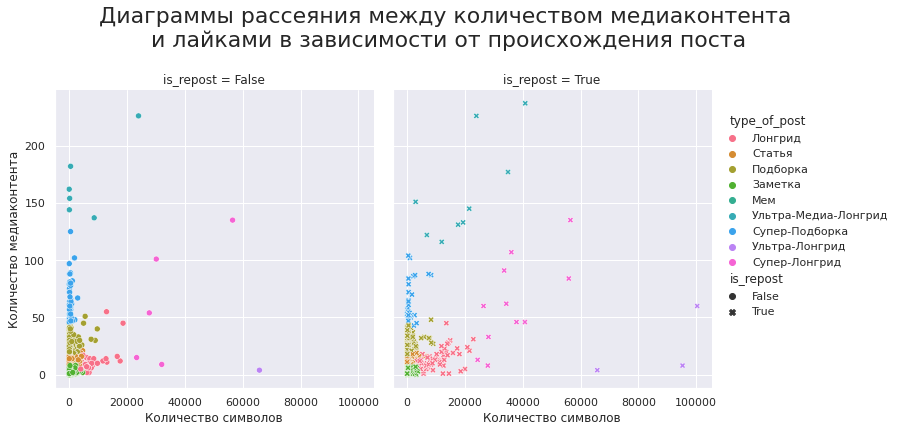

In [8]:
plt.rcParams["figure.figsize"] = [20, 16]
sns.set_theme()
sns.set_palette('hls')

g = sns.relplot(
    data=df, x="symbols", y="total_mediacontent",
    col="is_repost", hue="type_of_post", style="is_repost",
    kind="scatter", 
)
g.set_axis_labels("Количество символов", "Количество медиаконтента")

g.fig.suptitle('Диаграммы рассеяния между количеством медиаконтента \
\nи лайками в зависимости от происхождения поста', fontsize=22, y=1.15);

# plt.savefig(PATH + "Full_analysis/scatter_by_type_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

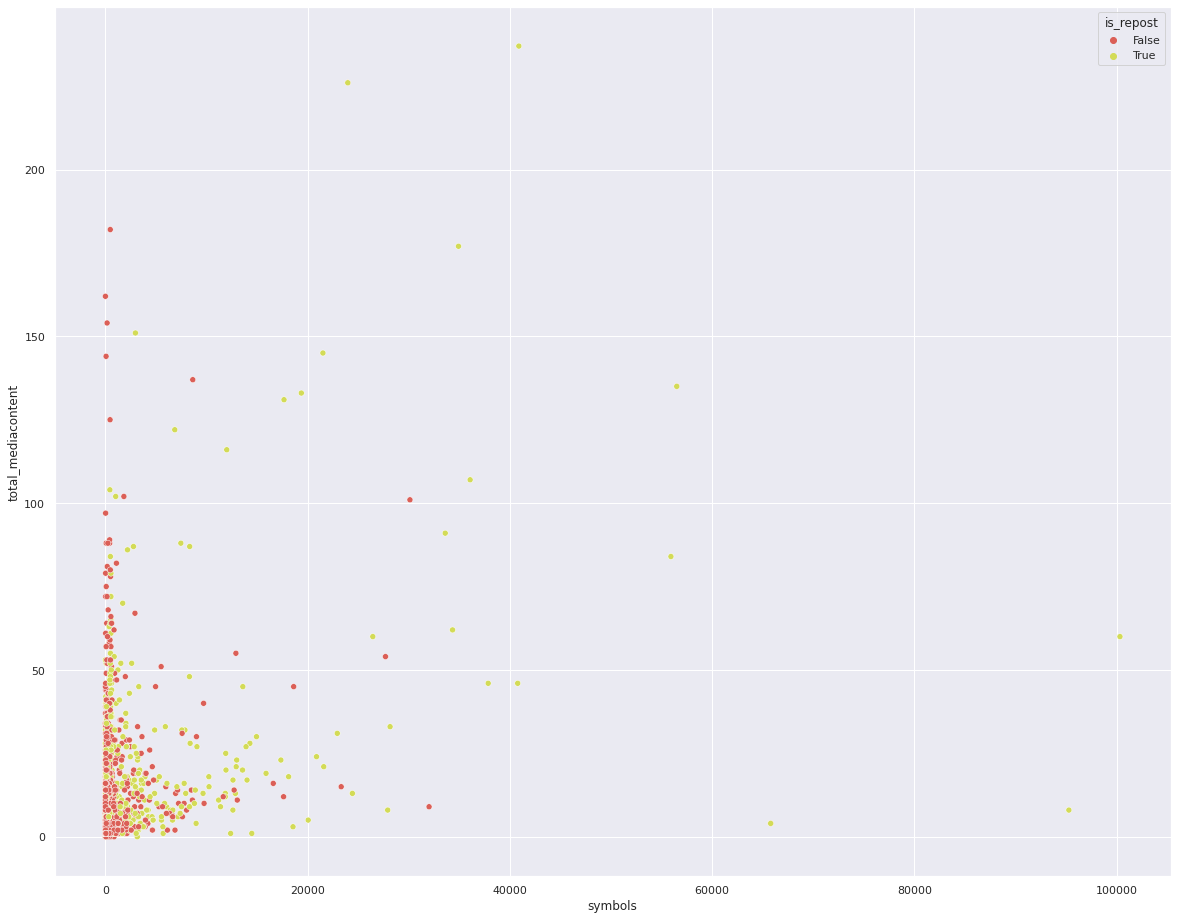

In [9]:
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue='is_repost', data=df)

<AxesSubplot:xlabel='comments_count', ylabel='Count'>

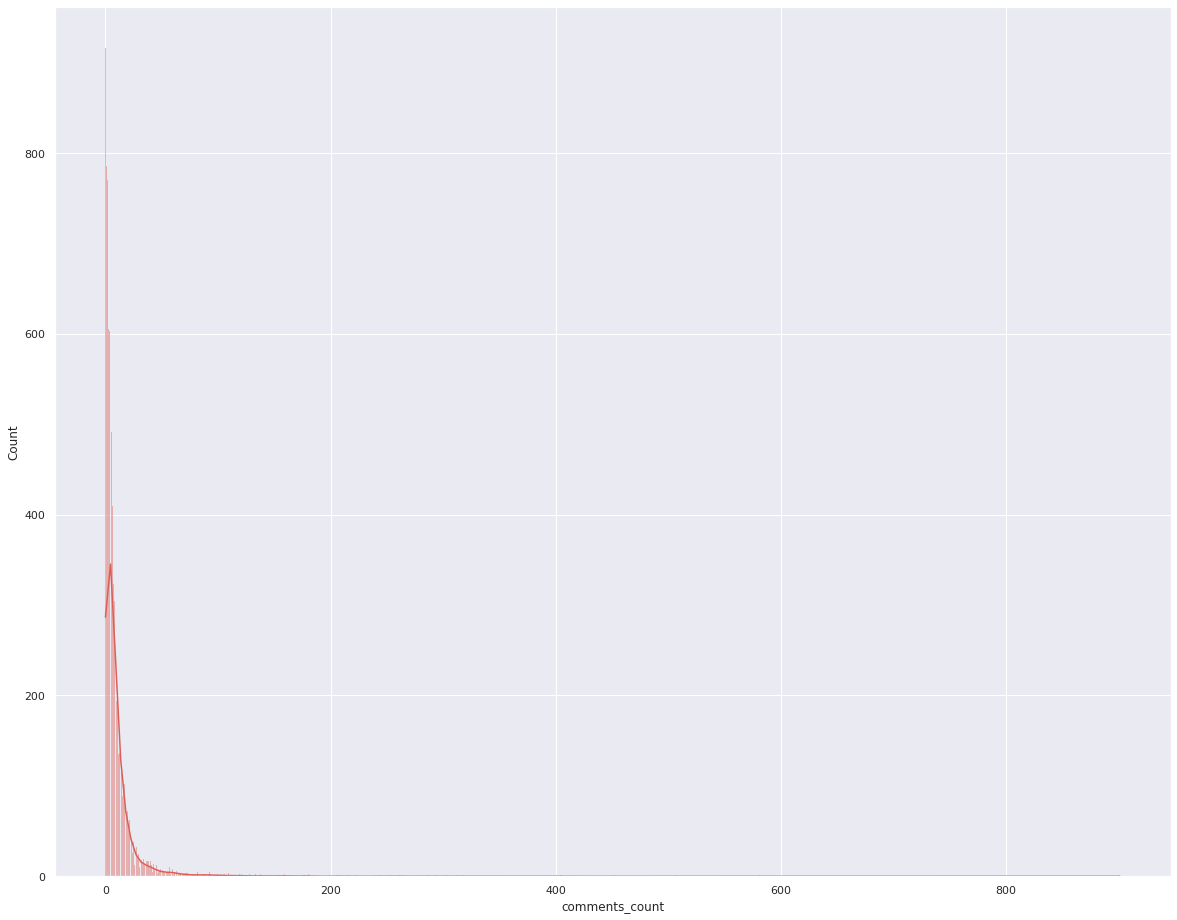

In [10]:
sns.histplot(x = df.comments_count, kde=True)

In [ ]:
# sns.boxplot(data=df, x="is_repost", y="likes")

In [ ]:
a = df.groupby(['author_name']).agg({'id': 'count'})
a[a['id'] > 1].sort_values(by='id', ascending=False)

In [ ]:
a[a['id'] > 100].index

In [ ]:
tmp = df.groupby(['author_name']).agg({'id': 'count'})

In [ ]:
# sns.boxplot(data=df, y="author_name", x="likes")

In [ ]:
# sns.violinplot(y=df.likes)

https://stackoverflow.com/questions/58665252/python-compare-distribution-scipy-ks-2samp-p-value-always-0-0

https://stats.stackexchange.com/questions/18408/two-samples-of-the-same-distribution

https://stackoverflow.com/questions/36846620/comparing-distributions-with-chi-square-in-python

https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [11]:
top_authors = ['олег уходи', 'Layben', 'Гусь Хмурый', 'Suzume-sama said OKawaii Koto',
       'Diego Paw', 'Фанат Ани Тейлор-Джой', 'Pray for Megumin', 'Just Chill',
       'Хасаги', 'Koda', 'Over9k5000', 'mindtered', 'Oleg Mattewho', 'Виабу',
       'Анимемания', 'YuruCamp каждый день', 'Алексей Кудрявцев', 'Saher',
       'Marshal_New_Arleana', 'Revendi', 'deGoose',
       'Некстгенова Элой Плэйстэйшовна', 'Asuka Soryu', 'Ржобек Пшеждзински',
       'Михаил Тучинский', 'Zerescas', 'Jooo Laalll20467', 'Kurisu Makise',
       'HiroariTillWhen', 'Khornit', 'Le mort joyeux', 'Knightmare',
       'unheilig', 'Петя Миров', 'Divergo', 'nahtigalka', 'Mr. Piccolo',
       'Анастасия Югова', 'Люблю Пиццу', 'StupidMaronGuy', 'Тимур Лебедев',
       'Валера Чумаков', 'IcEWaRRiOr', 'Kits R', 'BioHazardAlBatros', 'Bsod',
       'Maks-arr', 'Hero', 'Мимо Проходил', 'Андрей Тор4']

In [12]:
tmp_likes = df[df.is_repost == False][df['author_name'].isin(top_authors)]
tmp_likes.shape

<ipython-input-12-3e9d5fdcda27>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_likes = df[df.is_repost == False][df['author_name'].isin(top_authors)]


(5427, 31)

In [ ]:
tmp_likes.groupby(['author_name'], as_index=False)

In [ ]:
# tmp_likes = df[df.is_repost == False].groupby(['author_name'], as_index=False)
# tmp_likes.head(2)

In [ ]:
# len(tmp_likes.author_name.unique())

In [ ]:
# tmp_likes.shape

In [13]:
import matplotlib.patheffects as path_effects

plt.rcParams["figure.figsize"] = [14, 10]

def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{round(value)}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

Text(0.5, 1.0, 'Распределения количества лайков за публикации у различных авторов')

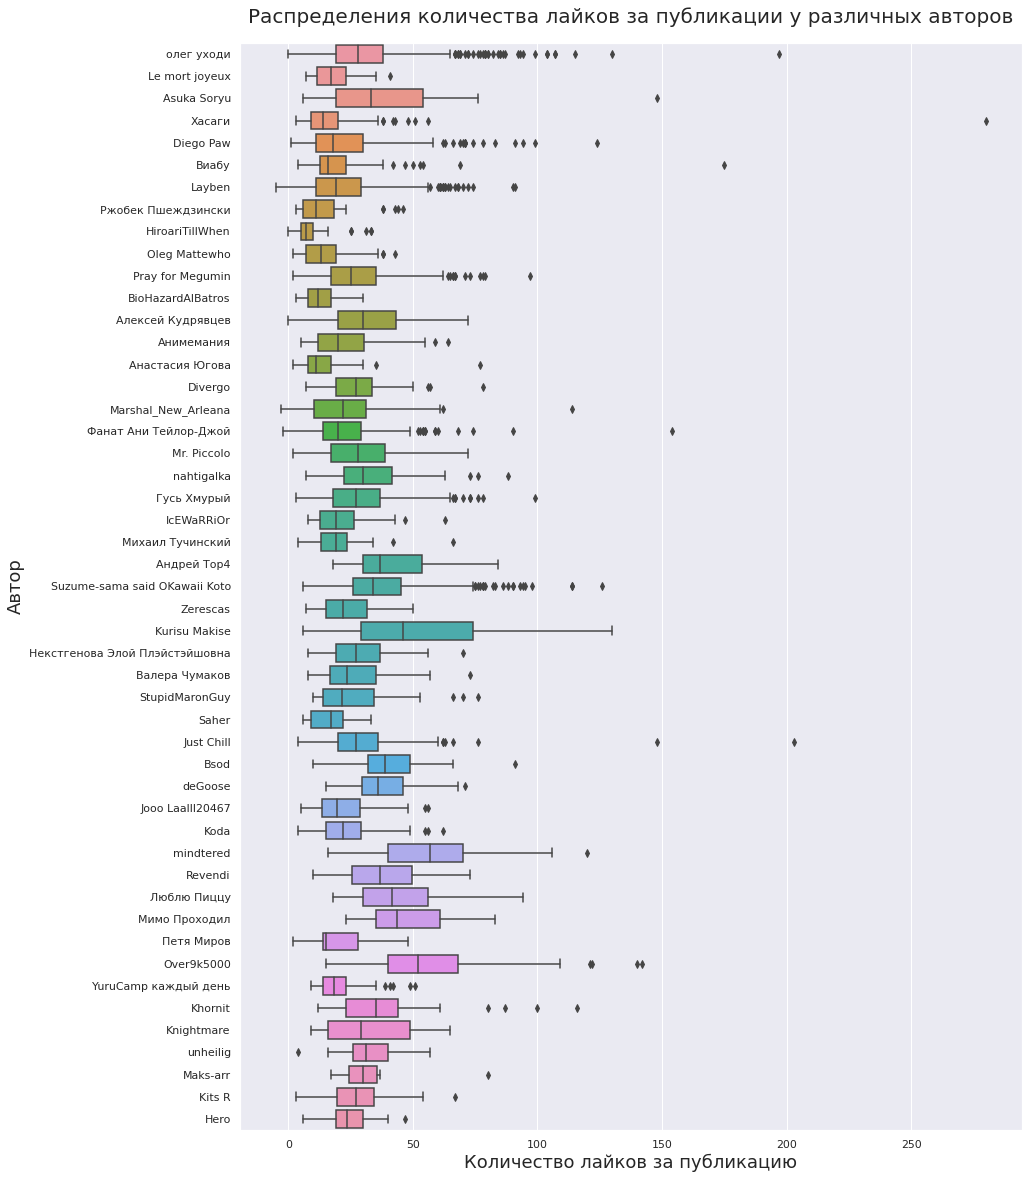

In [14]:
plt.rcParams["figure.figsize"] = [14, 20]
sns.set_theme()
ax = sns.boxplot(data=tmp_likes, y='author_name', x='likes')

# add_median_labels(ax.axes)

plt.xlabel('Количество лайков за публикацию', fontsize=18)
plt.ylabel('Автор', fontsize=18)
plt.title('Распределения количества лайков за публикации у различных авторов', fontsize=20, pad=20)
# plt.savefig(PATH + "Full_analysis/authors_boxplots.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.type_of_post.value_counts().values

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
# g = sns.catplot(x="is_repost", hue="type_of_post", data=df, #col='is_repost',
#                 height=10, dodge=True) #y="likes",


# def change_width(ax, new_value) :
#     for patch in element.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)

# change_width(g, .35)



# ax = g.facet_axis(0,0)
# for p in ax.patches:
#     ax.text(p.get_x(), 
#             p.get_height() * 1.0, 
#            '{}'.format(p.get_height()),   #Used to format it K representation
#             color='black', 
#             rotation='horizontal', 
#             size='large')
    
# ax = g.facet_axis(0,1)
# for p in ax.patches:
#     ax.text(p.get_x(), 
#             p.get_height() * 1.07, 
#            '{0}'.format(p.get_height()),   #Used to format it K representation
#             color='black', 
#             rotation='horizontal', 
#             size='large')

In [ ]:
sns.catplot(x="is_repost", hue="type_of_post", kind="count", data=df) #y="likes",

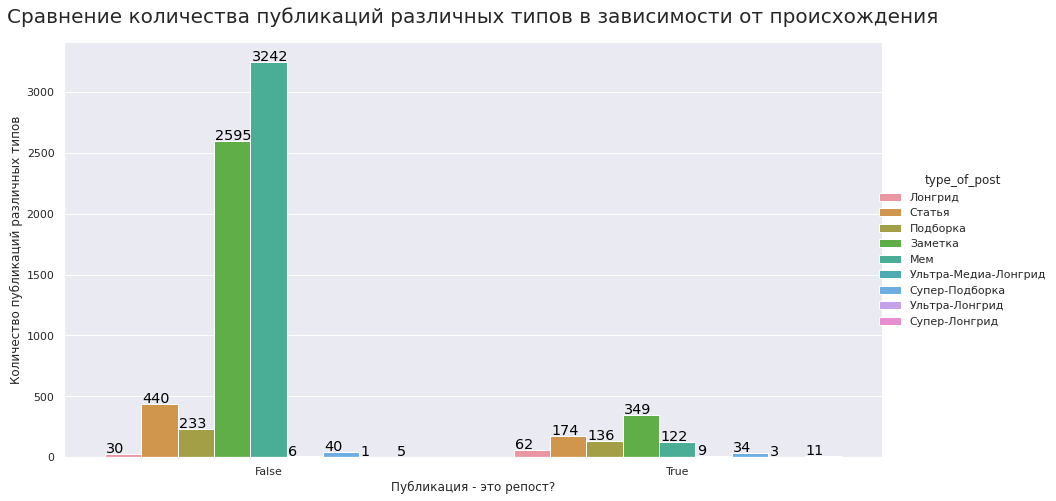

In [16]:
sns.set_palette('husl', 8)

g = sns.catplot(x="is_repost", hue="type_of_post", kind="count", data=df, legend=True)
g.fig.set_size_inches(16,8)
g.fig.subplots_adjust(top=0.81, right=0.85) 

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.003, 
            p.get_height() + 10, 
           '{}'.format(p.get_height()),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')
    
plt.xlabel('Публикация - это репост?')
plt.ylabel('Количество публикаций различных типов')
plt.title('Сравнение количества публикаций различных типов в зависимости от происхождения', 
          fontsize=20, pad=20) 

# plt.savefig(PATH + "Full_analysis/types_catplot.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df.groupby(['type_of_post'])['likes'].median()

Text(0.5, 1.0, 'Сравнение распределений лайков в зависимости от типа поста и происхождения публикации')

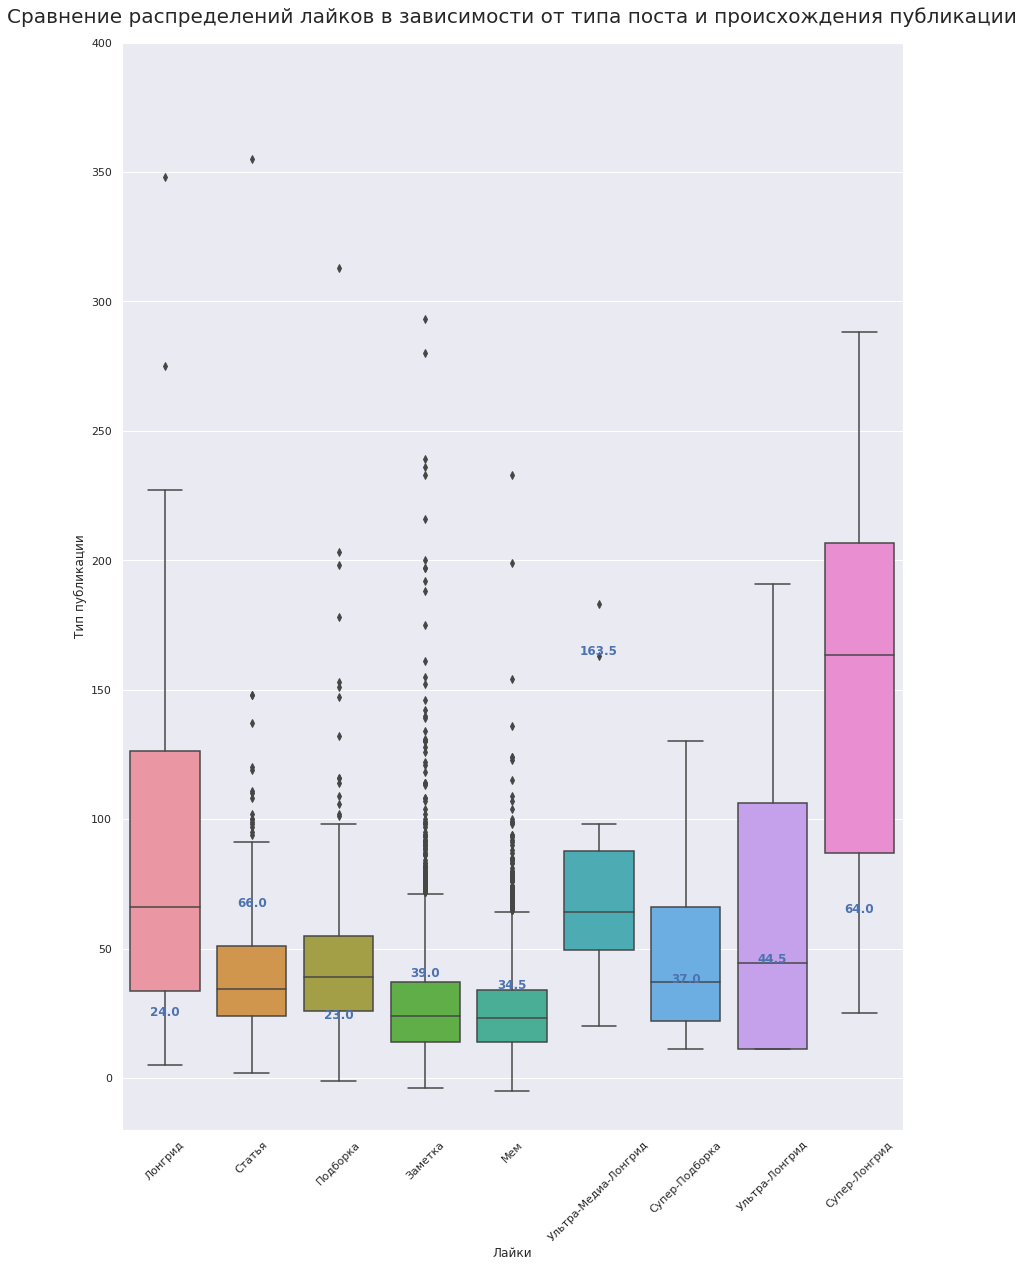

In [17]:
box_plot = sns.boxplot(x="type_of_post", y="likes", data=df)    
medians = df.groupby(['type_of_post'])['likes'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick], medians[xtick], 
            horizontalalignment='center', color='b', weight='semibold')    
    
plt.xticks(rotation=45)
plt.ylim(-20, 400)
plt.xlabel('Лайки')
plt.ylabel('Тип публикации')
plt.title('Сравнение распределений лайков в зависимости от типа поста и происхождения публикации', 
          fontsize=20, pad=20)    
    
# plt.savefig(PATH + "Full_analysis/types_likes_boxplots.jpg", dpi=300, bbox_inches='tight')

In [69]:
import matplotlib.patheffects as path_effects

plt.rcParams["figure.figsize"] = [14, 10]

def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.1f}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

In [482]:
sns.set_palette('husl', 8)

Text(0.5, 1.0, 'Сравнение распределений количества символов в зависимости от типа поста')

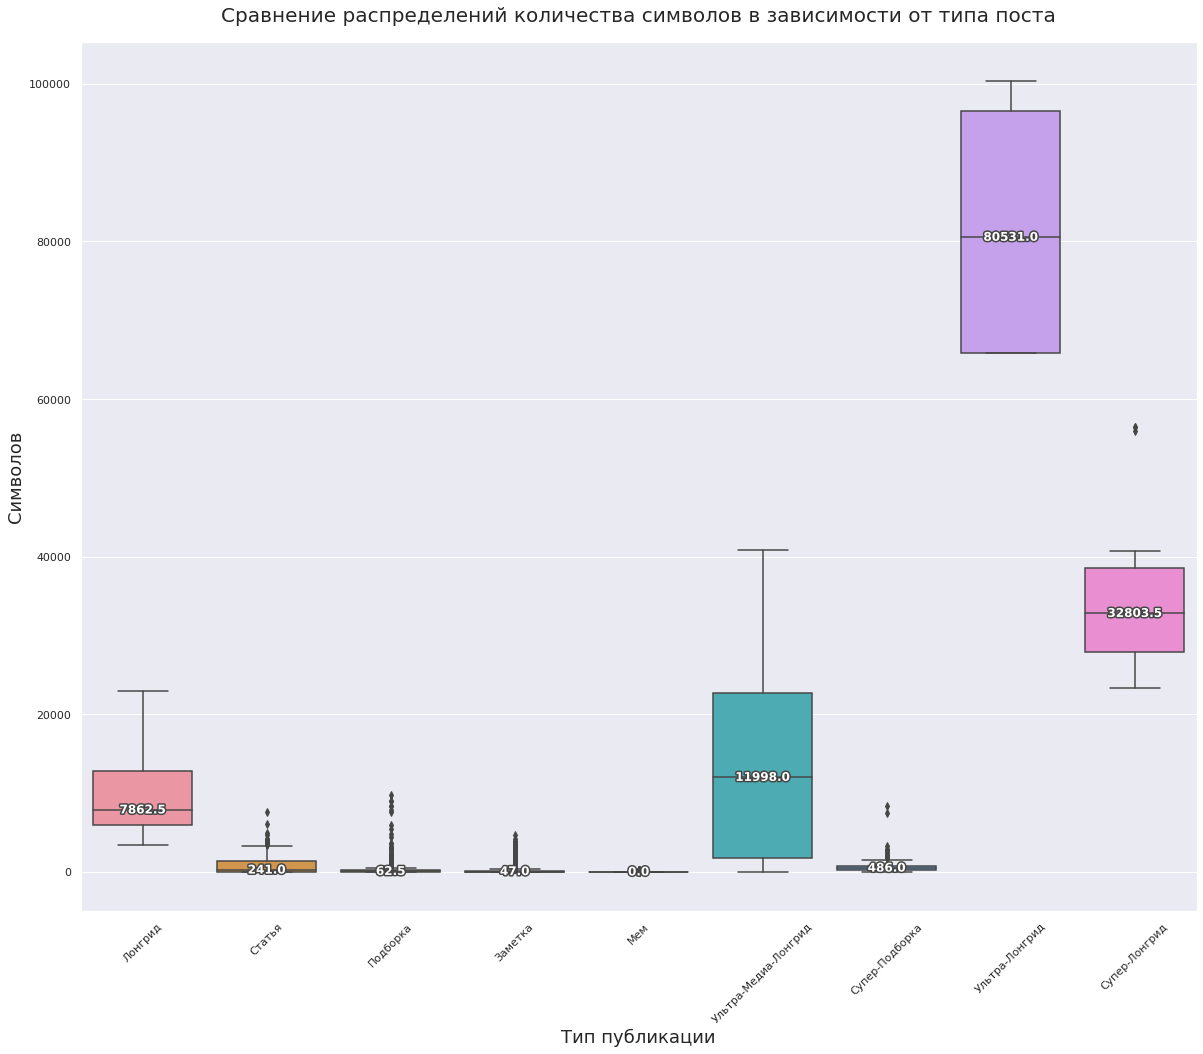

In [493]:
box_plot = sns.boxplot(x="type_of_post", y="symbols", data=df) # y='likes', y='hits_count', 'favorites_count', 'comments_count'
add_median_labels(box_plot.axes)
plt.xticks(rotation=45)
# plt.ylim(-20, 400) # COMMENT THIS!
# plt.ylim(0, 400) # COMMENT THIS!
# plt.ylim(0, 20000) # COMMENT THIS!
plt.xlabel('Тип публикации', fontsize=18)
plt.ylabel('Символов', fontsize=18)
plt.title('Сравнение распределений количества символов в зависимости от типа поста', 
          fontsize=20, pad=20) 
# plt.show()
    
# plt.savefig(PATH + "Full_analysis/all_types_symbols_boxplots.jpg", dpi=300, bbox_inches='tight')

In [497]:
7862 / 241

32.62240663900415

Text(0.5, 1.0, 'Сравнение распределений количества медиаконтента в зависимости от типа поста')

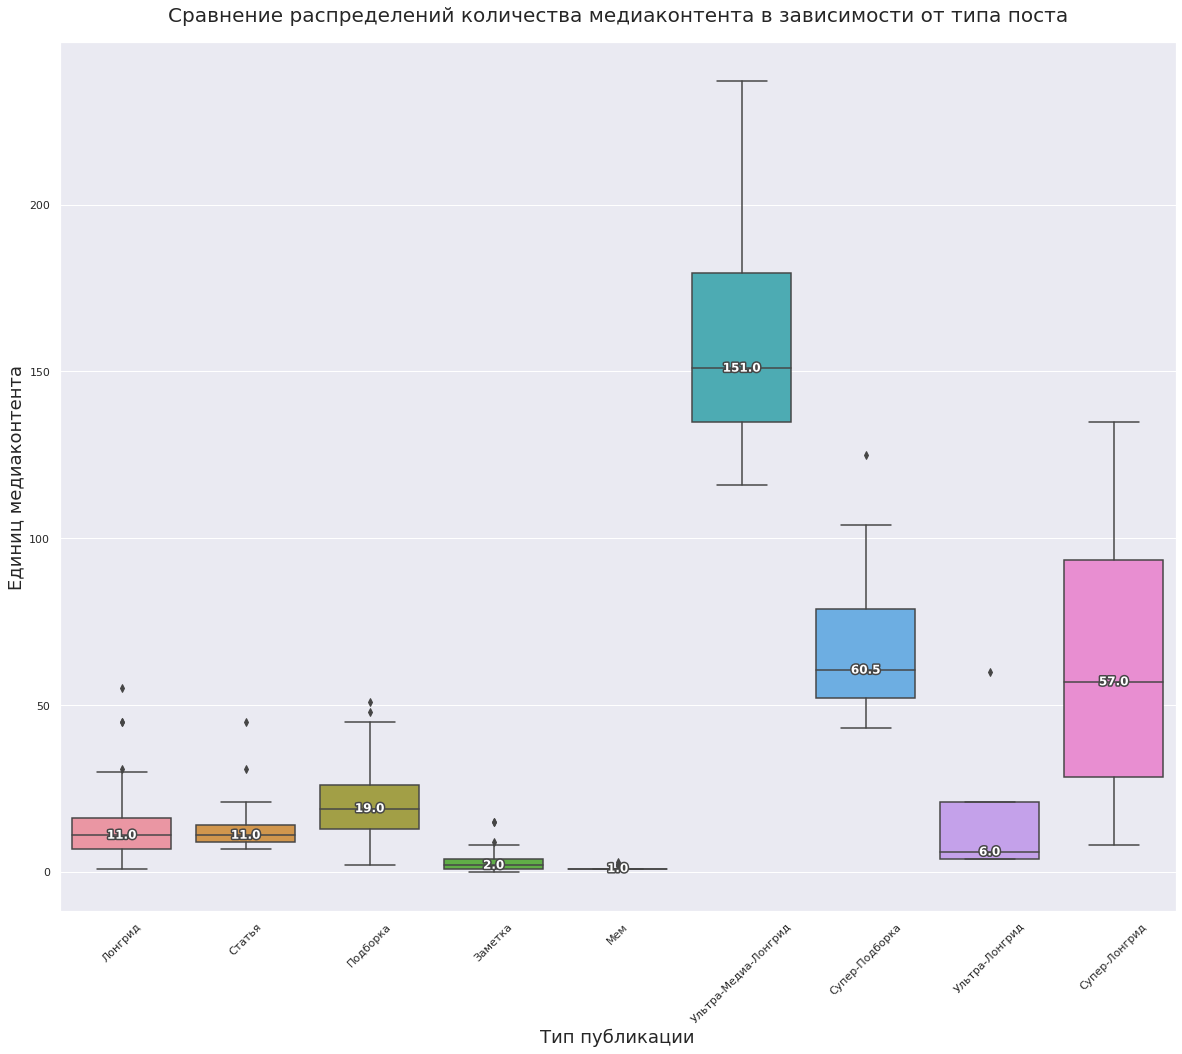

In [496]:
box_plot = sns.boxplot(x="type_of_post", y="total_mediacontent", data=df) # y='likes', y='hits_count', 'favorites_count', 'comments_count'
add_median_labels(box_plot.axes)
plt.xticks(rotation=45)
# plt.ylim(-20, 400) # COMMENT THIS!
# plt.ylim(0, 400) # COMMENT THIS!
# plt.ylim(0, 20000) # COMMENT THIS!
plt.xlabel('Тип публикации', fontsize=18)
plt.ylabel('Единиц медиаконтента', fontsize=18)
plt.title('Сравнение распределений количества медиаконтента в зависимости от типа поста', 
          fontsize=20, pad=20) 
# plt.show()
    
# plt.savefig(PATH + "Full_analysis/all_types_media_boxplots.jpg", dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Сравнение распределений количества комментариев в зависимости от типа поста')

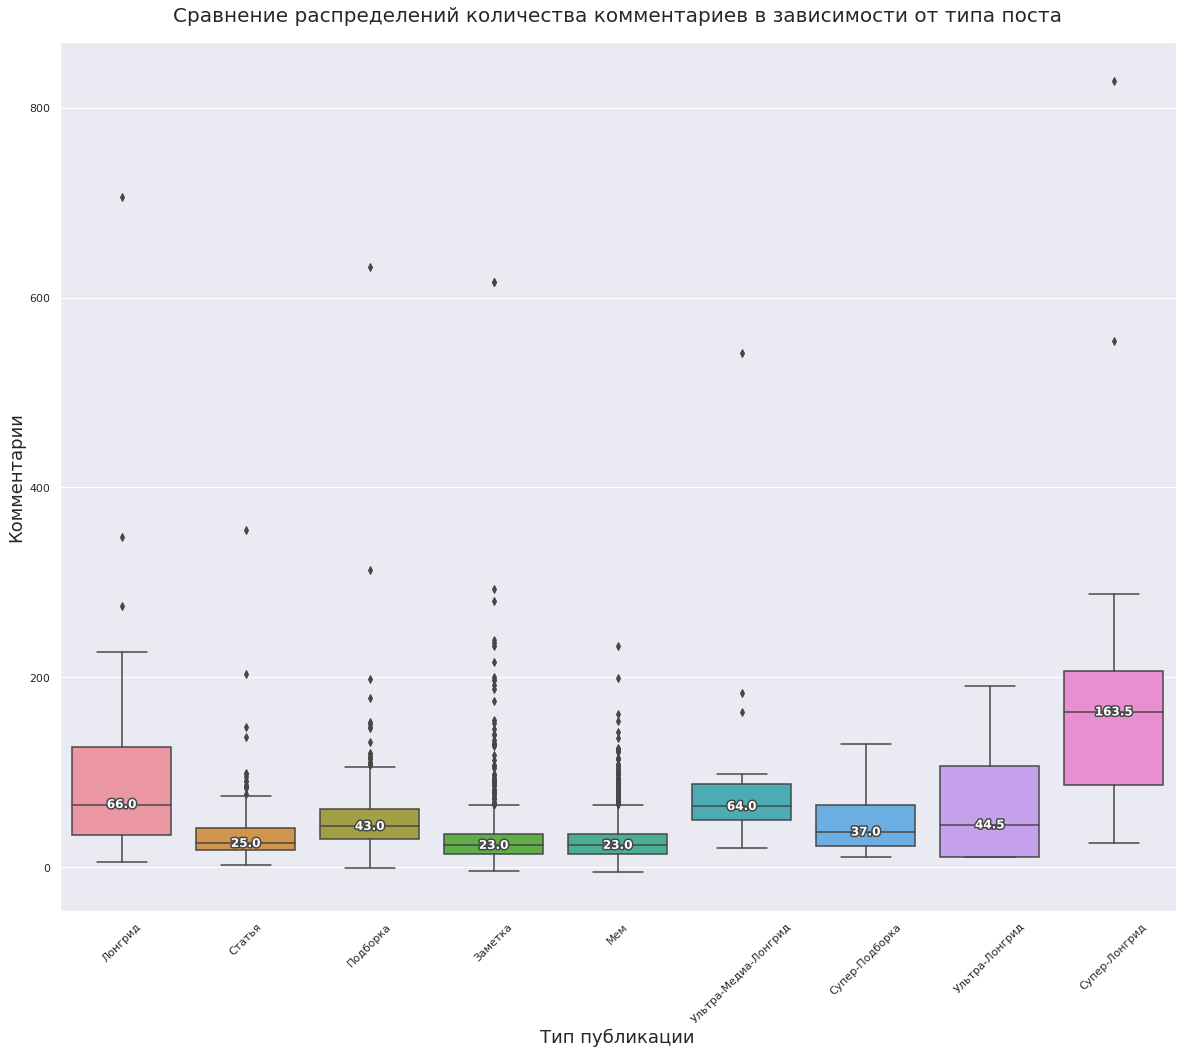

In [489]:
box_plot = sns.boxplot(x="type_of_post", y="likes", data=df) # y='likes', y='hits_count', 'favorites_count', 'comments_count'
add_median_labels(box_plot.axes)
plt.xticks(rotation=45)
# plt.ylim(-20, 400) # COMMENT THIS!
# plt.ylim(0, 400) # COMMENT THIS!
# plt.ylim(0, 20000) # COMMENT THIS!
plt.xlabel('Тип публикации', fontsize=18)
plt.ylabel('Комментарии', fontsize=18)
plt.title('Сравнение распределений количества комментариев в зависимости от типа поста', 
          fontsize=20, pad=20) 
# plt.show()
    
# plt.savefig(PATH + "Full_analysis/all_types_likes_boxplots_2.jpg", dpi=300, bbox_inches='tight')

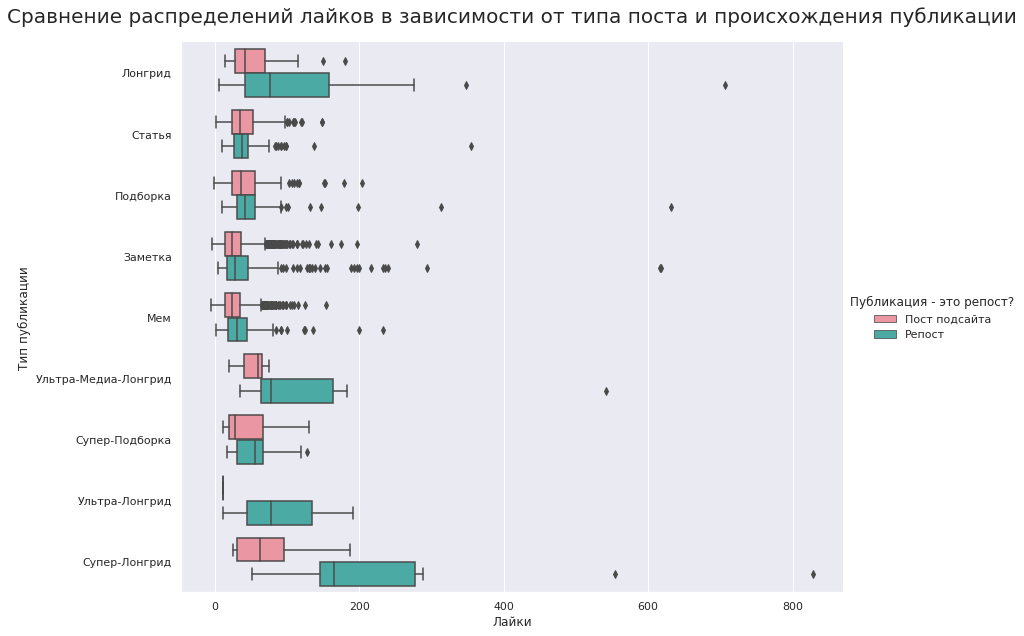

In [48]:
sns.set_palette('husl', 1)
g = sns.catplot(y="type_of_post", x="likes", hue="is_repost", kind="box", 
            data=df, height=8.27, aspect=11.7/8.27) 
# title
new_title = 'Публикация - это репост?'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Пост подсайта', 'Репост']
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)
plt.xlabel('Лайки')
plt.ylabel('Тип публикации')
plt.title('Сравнение распределений лайков в зависимости от типа поста и происхождения публикации', 
          fontsize=20, pad=20)
# plt.savefig(PATH + "Full_analysis/types_likes_boxplots.jpg", dpi=300, bbox_inches='tight')

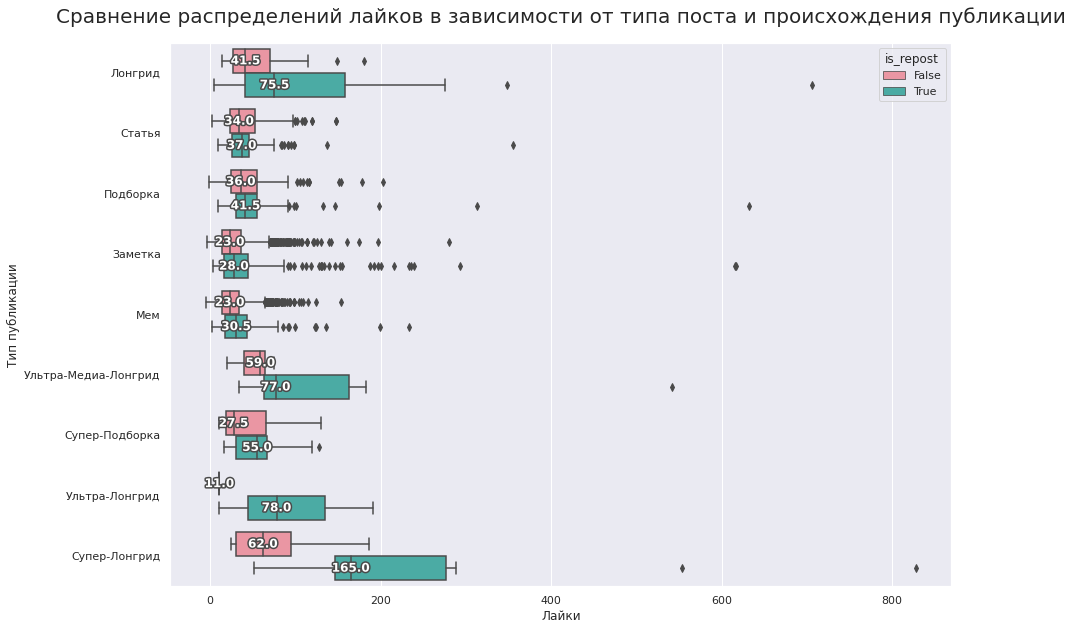

In [49]:
sns.set_theme()
sns.set_palette('husl', 1)
g = sns.boxplot(y="type_of_post", x="likes", hue="is_repost", #kind="box", 
            data=df, 
               ) 

add_median_labels(g.axes)

plt.xlabel('Лайки')
plt.ylabel('Тип публикации')
plt.title('Сравнение распределений лайков в зависимости от типа поста и происхождения публикации', 
          fontsize=20, pad=20)

# plt.savefig(PATH + "Full_analysis/types_likes_boxplots_additional.jpg", dpi=300, bbox_inches='tight')

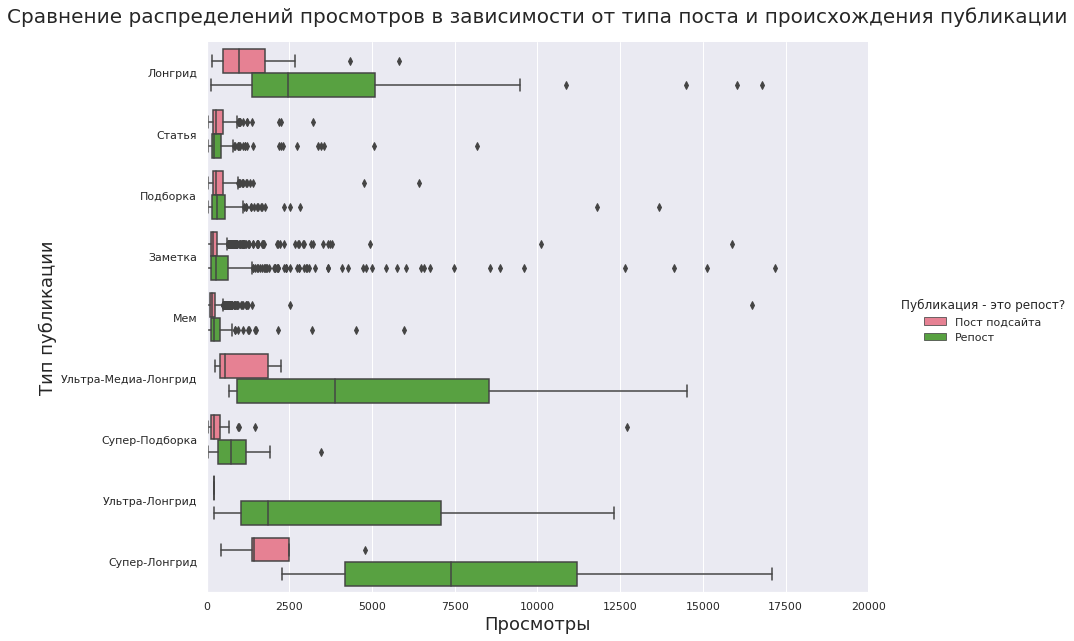

In [50]:
sns.set_palette('husl', 3)
g = sns.catplot(y="type_of_post", x="hits_count", hue="is_repost", kind="box", 
            data=df, height=8.27, aspect=11.7/8.27) 
#----
new_title = 'Публикация - это репост?'
g._legend.set_title(new_title)
new_labels = ['Пост подсайта', 'Репост']
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)
#----
plt.xlim(0, 20000)
plt.xlabel('Просмотры', fontsize=18)
plt.ylabel('Тип публикации', fontsize=18)
plt.title('Сравнение распределений просмотров в зависимости от типа поста и происхождения публикации', 
          fontsize=20, pad=20)

# plt.savefig(PATH + "Full_analysis/types_hits_boxplots.jpg", dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Сравнение распределений просмотров в зависимости от типа поста и происхождения публикации')

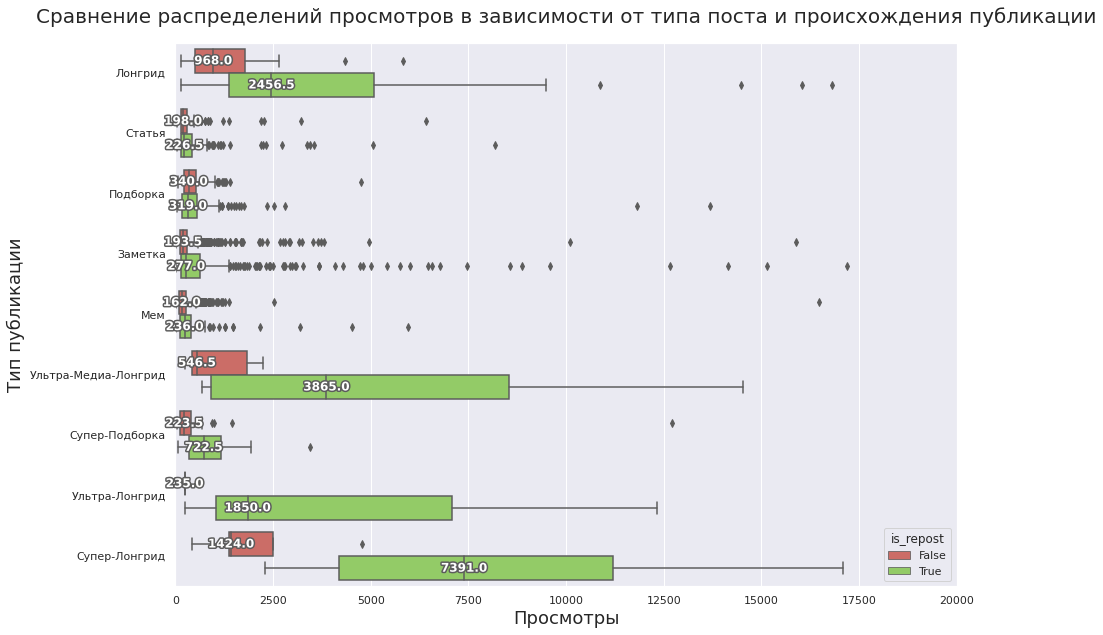

In [70]:
g = sns.boxplot(y="type_of_post", x="hits_count", hue="is_repost", 
            data=df, 
               ) 
add_median_labels(g.axes)

plt.xlim(0, 20000)
plt.xlabel('Просмотры', fontsize=18)
plt.ylabel('Тип публикации', fontsize=18)
plt.title('Сравнение распределений просмотров в зависимости от типа поста и происхождения публикации', 
          fontsize=20, pad=20)
# plt.savefig(PATH + "Full_analysis/types_hits_boxplots_additional.jpg", dpi=300, bbox_inches='tight')

Судя по диаграммам, ситуация обстоит таким образом: если задача заключается в том, чтобы получить как можно большей лайков, то в подсайт стоит постить: статьи, подборки и супер-подборки. По просмотрам публикации подсайта серьёзно уступают репостам, разве что кроме статьей. Заметки, статьи и мемы имеют большое количество аномальных значений - это вызвано сильным дисбалансом классов. Указанных классов в разы больше прочих, следовательно и аномалий в них больше. Также, причиной большого числа выбросов может быть не вполне корректная классификация.

In [ ]:
# tmp_copy = tmp.copy()
# tmp_copy

In [ ]:
# for i in tmp_copy.index:
# #     print(tmp_copy.loc[i].title)
#     if type(tmp_copy.loc[i].title) == float:
#         print('AAAAAAAAAAAA!!!')
#         tmp_copy_str = tmp_copy.loc[i, 'author_name']
#         print(f'Запись пользователя {tmp_copy_str}')
    

In [ ]:
# for i in tmp_copy.index:
#     if type(tmp_copy.loc[i].title) == float:
#         tmp_copy_str = tmp_copy.loc[i, 'author_name']
# #         print(tmp_copy_str)
#         tmp_copy.loc[i, 'title'] = f'Запись пользователя {tmp_copy_str}'
# tmp_copy

In [ ]:
# tmp_copy

<AxesSubplot:xlabel='symbols', ylabel='total_mediacontent'>

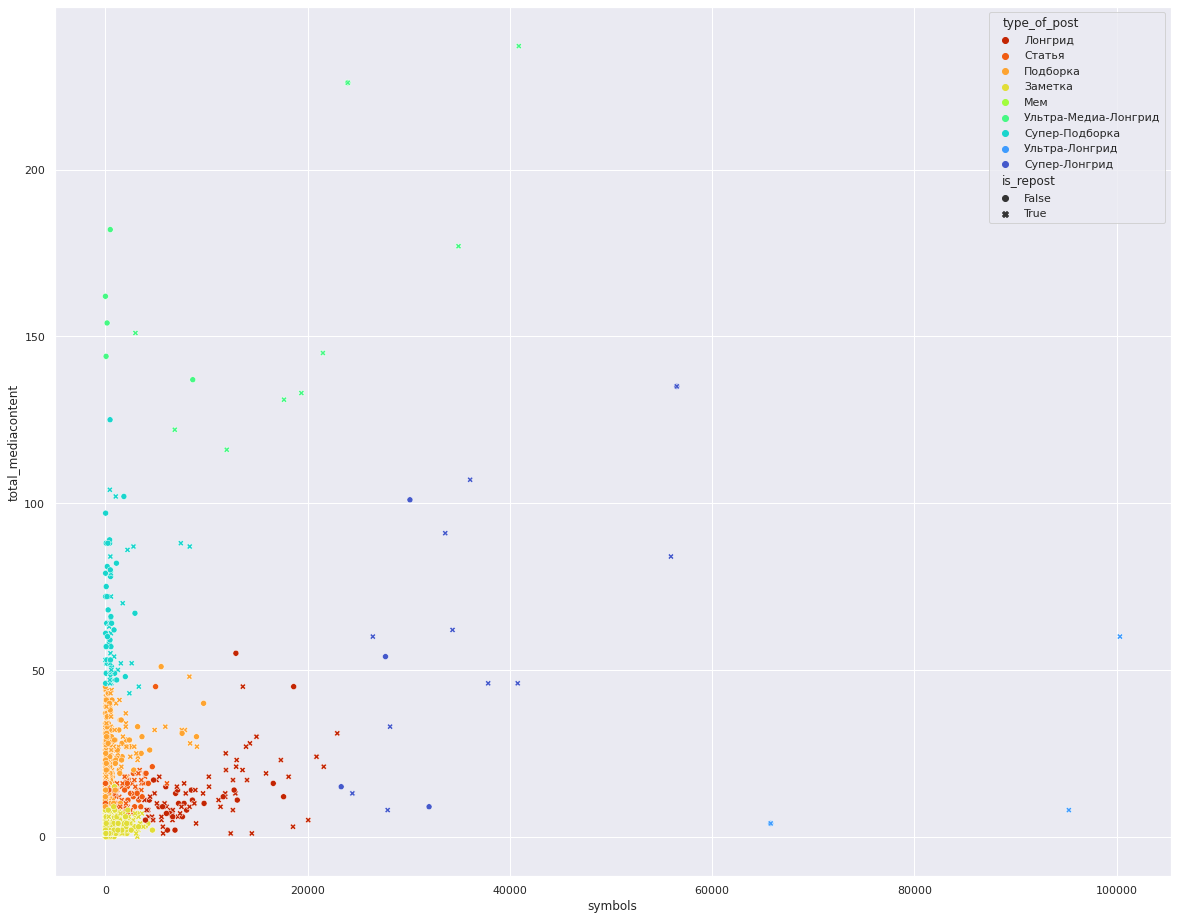

In [71]:
plt.rcParams["figure.figsize"] = [20, 16]

sns.scatterplot(data=df, x="symbols", y="total_mediacontent", hue="type_of_post", 
                style="is_repost", palette='turbo_r')

In [99]:
df.type_of_post.unique()

array(['Лонгрид', 'Статья', 'Подборка', 'Заметка', 'Мем',
       'Ультра-Медиа-Лонгрид', 'Супер-Подборка', 'Ультра-Лонгрид',
       'Супер-Лонгрид'], dtype=object)

In [480]:
df = pd.read_pickle(PATH + 'Full_analysis/Analysed_weaboo_data_02_05.pkl')
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,Лонгрид
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,Статья
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,Подборка
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,Подборка
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,Лонгрид


In [ ]:
# tmp_4.loc[137, 'title'] = 'СМЕНА НАЗВАНИЯ ПУБЛИКАЦИИ'

In [55]:
# df.loc[7083, 'type_of_post'] = 'Статья'
# df.loc[7202, 'type_of_post'] = 'Заметка' #'Подборка'
# df.loc[5184, 'type_of_post'] = 'Подборка'

# df.loc[2351, 'type_of_post'] = 'Подборка'

In [197]:
tmp = df[(df.is_repost == False) & (df.type_of_post == 'Подборка')].sort_values(by='comments_count', ascending=False) \
.head(20).loc[:, ["id", 'url', 'author_name', 'title', "comments_count"]] 
# 'likes', 'hits_count', 'favorites_count', 'comments_count'
# tmp_4.loc[137, 'title'] = 'СМЕНА НАЗВАНИЯ ПУБЛИКАЦИИ'
# tmp.drop(3345, inplace=True)
# tmp.drop(5205, inplace=True)
tmp

,id,url,author_name,title,comments_count
3819,271436,https://dtf.ru/s/weaboo/271436-glavnaya-devoch...,олег уходи,Главная девочка декабря (Победитель - Макисе К...,176
519,179857,https://dtf.ru/s/weaboo/179857-vnutri-ban,олег уходи,внутри бан?,125
7083,700511,https://dtf.ru/s/weaboo/700511-itogi-konkursa-...,Kurisu Makise,"Итоги конкурса ""Японская школа в весенний сезон""",87
5708,644897,https://dtf.ru/s/weaboo/644897-podborka-loli-a...,Петя Миров,Подборка лоли артов😏,62
5056,611208,https://dtf.ru/s/weaboo/611208-kartinki,Koda,Картинки,56
2848,239959,https://dtf.ru/s/weaboo/239959-devushki-iz-per...,Kurisu Makise,Девушки из Persona5,48
2943,242223,https://dtf.ru/s/weaboo/242223-glavnaya-devoch...,олег уходи,Главная девочка ноября,47
5919,656518,https://dtf.ru/s/weaboo/656518-pomoshch-zagrus...,Pray for Megumin,Помощь загрустившим :3,47
817,188244,https://dtf.ru/s/weaboo/188244-hochu-pyva,Le mort joyeux,Хочу пыва,43
3485,258606,https://dtf.ru/s/weaboo/258606-devushki-prekra...,Kurisu Makise,Девушки прекрасны #2,42


In [73]:
print(len(df.type_of_post.unique()))
print(df.type_of_post.unique())

9
['Лонгрид' 'Статья' 'Подборка' 'Заметка' 'Мем' 'Ультра-Медиа-Лонгрид'
 'Супер-Подборка' 'Ультра-Лонгрид' 'Супер-Лонгрид']


In [198]:
for i in tmp.index:
    if type(tmp.loc[i].title) == float:
        tmp_str = tmp.loc[i, 'author_name']
        tmp.loc[i, 'title'] = f'Запись пользователя {tmp_str}' #Запись пользователя 
#         tmp.loc[i, 'title'] = tmp.loc[i, 'title']
#     print(len(tmp.loc[i, 'title']), i)
#     tmp.loc[i, 'title'] = tmp.loc[i, 'title'][:10] + '...'
        
tmp

,id,url,author_name,title,comments_count
3819,271436,https://dtf.ru/s/weaboo/271436-glavnaya-devoch...,олег уходи,Главная девочка декабря (Победитель - Макисе К...,176
519,179857,https://dtf.ru/s/weaboo/179857-vnutri-ban,олег уходи,внутри бан?,125
7083,700511,https://dtf.ru/s/weaboo/700511-itogi-konkursa-...,Kurisu Makise,"Итоги конкурса ""Японская школа в весенний сезон""",87
5708,644897,https://dtf.ru/s/weaboo/644897-podborka-loli-a...,Петя Миров,Подборка лоли артов😏,62
5056,611208,https://dtf.ru/s/weaboo/611208-kartinki,Koda,Картинки,56
2848,239959,https://dtf.ru/s/weaboo/239959-devushki-iz-per...,Kurisu Makise,Девушки из Persona5,48
2943,242223,https://dtf.ru/s/weaboo/242223-glavnaya-devoch...,олег уходи,Главная девочка ноября,47
5919,656518,https://dtf.ru/s/weaboo/656518-pomoshch-zagrus...,Pray for Megumin,Помощь загрустившим :3,47
817,188244,https://dtf.ru/s/weaboo/188244-hochu-pyva,Le mort joyeux,Хочу пыва,43
3485,258606,https://dtf.ru/s/weaboo/258606-devushki-prekra...,Kurisu Makise,Девушки прекрасны #2,42


In [202]:
tmp.loc[624, 'title'] = 'В мире не так много художников с академ...'
tmp.loc[5718, 'title'] = 'Чулочки, каре и немного игривости от infi...'
# tmp.loc[5744, 'title'] = 'Спорт, офис, чулочки и жаркое лето...'
# tmp.loc[6498, 'title'] = 'Подборка сканов из сборника Paint It...'
tmp.loc[6131, 'title'] = 'Воскресная подборка красивых дев в...'
# tmp.loc[3819, 'title'] = 'Главная девочка декабря (Победитель - М...'

# tmp.loc[4966, 'title'] = 'Понятие сталкинга и его отражение в японской культ...'
# tmp.loc[5195, 'title'] = 'КЗМ "Мрачный жнец и четыре подруги"...'
# tmp.loc[5200, 'title'] = 'От мобильных телефонов в ко...'
# tmp.loc[5942, 'title'] = 'Neko no Otera no Chion-san - Под...'
# tmp.loc[5081, 'title'] = 'Кто такие «Вайфу»: ранжируем анимедевочек ...'
# tmp.loc[6956, 'title'] = 'Становление полноценным человеко...'
# tmp.loc[5616, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как не надо...'
# tmp.loc[4890, 'title'] = 'О виабушнике Ташкент...'
# tmp.loc[647, 'title'] = 'Чем любительские субтитры лучше о...'
# tmp.loc[6250, 'title'] = 'Jumyou wo Kaitotte Moratta. Ichinen...'
# tmp.loc[5176, 'title'] = 'Лучшее российское ани...'
# tmp.loc[7362, 'title'] = 'Хентай манга после которой не...'
# tmp.loc[990, 'title'] = 'Несколько слов о юри-новелле...'
# tmp.loc[6250, 'title'] = 'Jumyou wo Kaitotte Moratta. Ichi...'
# tmp.loc[647, 'title'] = 'Чем любительские субтитры лучше официаль...'
# tmp.loc[5025, 'title'] = 'Пришел за фансервисом, остался ра...'
# tmp.loc[6956, 'title'] = 'Становление полноценным чел...'
# tmp.loc[7362, 'title'] = 'Хентай манга после которой не...'

# tmp.loc[273, 'title'] = 'Новый подсайт по тематике аниме, манга...'
# tmp.loc[7475, 'title'] = 'Раздача ключа от Resident Evil Village на...'
# tmp.loc[5517, 'title'] = 'Отзыв на мангу "О том, как я умру, е...'
# tmp.loc[7199, 'title'] = 'Аниме-адаптация манги Gokushu...'
# tmp.loc[7199, 'title'] = 'Аниме-адаптация манги Gokushufudou стала самым популярным шоу в японск...'
# tmp.loc[822, 'title'] = 'Машинное обучение превращает реальные фотограф...'
# tmp.loc[4370, 'title'] = 'Аниме «Семинар извращенцев»: немного грязи в ...'
# tmp.loc[273, 'title'] = 'Новый подсайт по тематике аниме, манга и все ч...'
# tmp.loc[7402, 'title'] = 'В американском PS Store раньше...'
# tmp.loc[3787, 'title'] = 'Weeaboo News: загадочн...'
# tmp.loc[986, 'title'] = 'Playboard: виртуальный...'
# tmp.loc[538, 'title'] = 'Официальные наручн...'
# tmp.loc[19, 'title'] = 'Новый подсайт об...'
# tmp.loc[77, 'title'] = 'На китайской верс...'
# tmp.loc[6444, 'title'] = '50 лайков этой милой тян или завтра я запощу гяру подборку...'
# tmp.loc[5019, 'title'] = 'После твита Илона Маска с аниме девочкой, акции компании выросли...'
# tmp.loc[5398, 'title'] = 'Пацаны, попробуем бустануть до 20 000 или ну...'
# tmp.loc[6767, 'title'] = 'Всем котяткам доброго утра, больше сил и...'
# tmp.loc[4124, 'title'] = 'Сегодня свой день рождения отмечает Ми...'
# tmp.loc[6671, 'title'] = 'Приятного аппетита всем кто кушает и с началом...'
# tmp.loc[6491, 'title'] = 'Утренняя подборка с блинчик...'
# tmp.loc[7419, 'title'] = 'Очаровательная вампирша и другие...'
# tmp.loc[7228, 'title'] = 'Арты по Yuru...'
# tmp.loc[4930, 'title'] = 'Девушки в...'
# tmp.loc[3152, 'title'] = 'Киберпанк...'
# tmp.loc[553, 'title'] = '101 GIF Ани...'
# tmp.loc[3105, 'title'] = 'Виабу захватил Киберпанк и орг...'
# tmp.loc[5435, 'title'] =  'Сегодня день рождения у Аобы Судз...'
# tmp.loc[3311, 'title'] = 'Конкурс КиберВиабу. Рез...'
# tmp.loc[2875, 'title'] = 'Хана и Алиса: Дело об уб...'
# tmp.loc[5339, 'title'] = 'Главная девочка февр...'
# tmp.loc[528, 'title'] = 'вечерний SFW (re:zero 2'
# tmp.loc[7083, 'title'] = 'Итоги конкурса "Японская школа...'

In [63]:
# sns.set_theme()

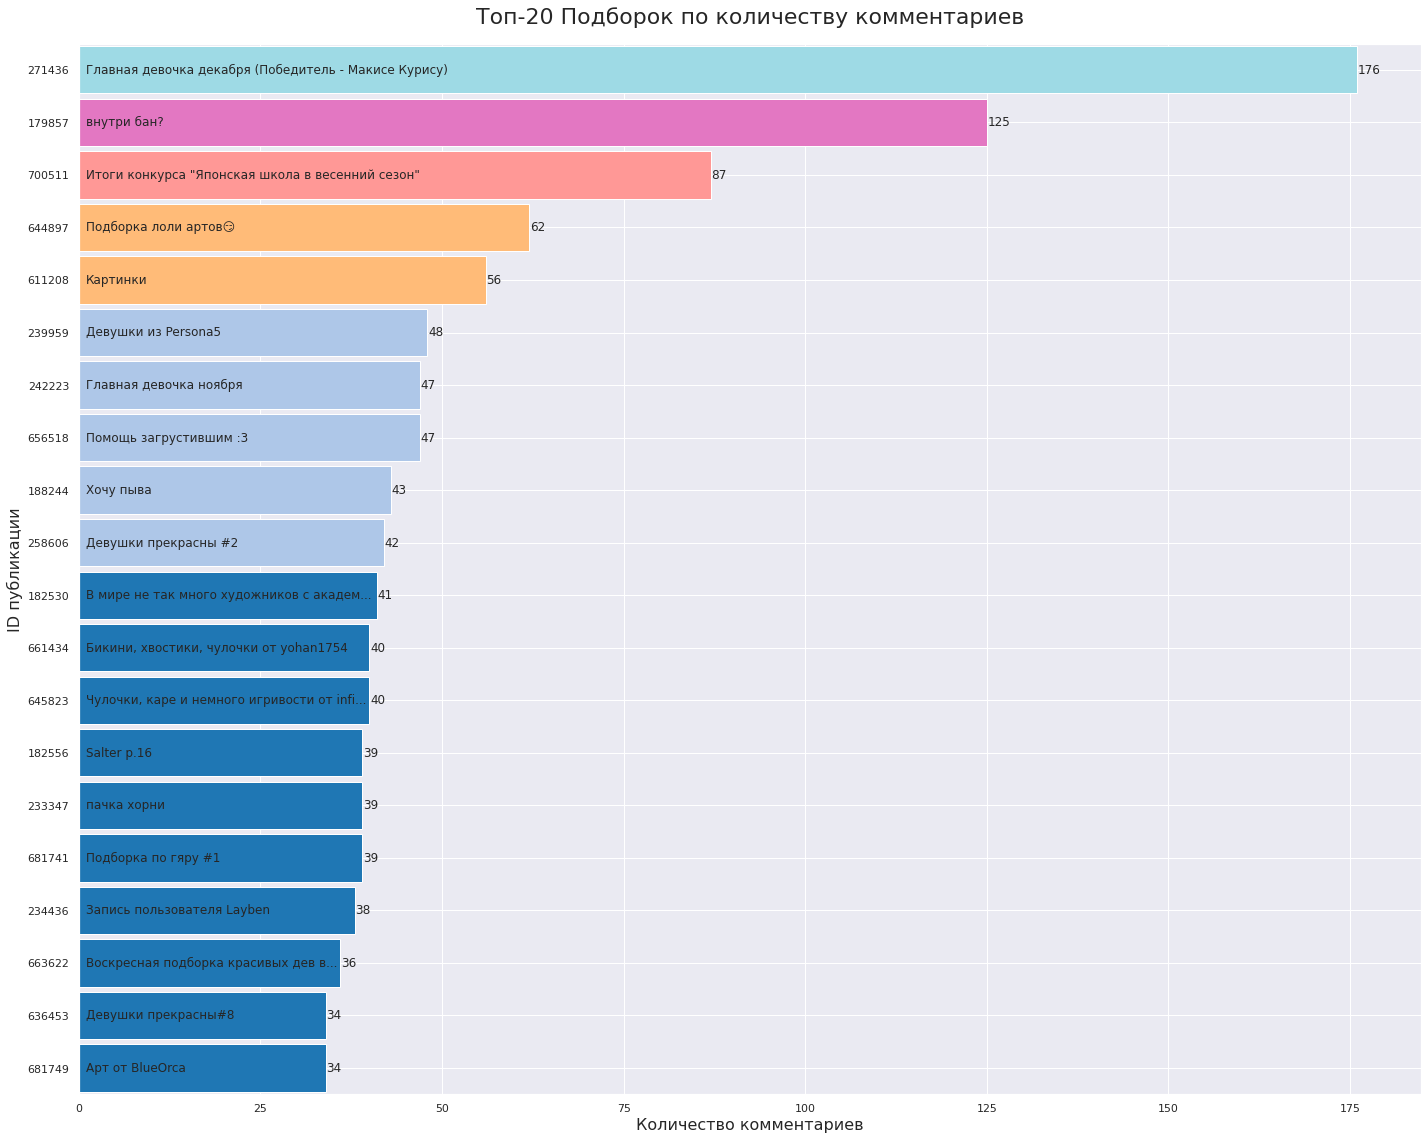

In [203]:
from matplotlib import cm

labels = tmp.title[::-1]#.astype('str')
values = tmp.comments_count[::-1]

my_cmap = plt.get_cmap("tab20") #cool_r
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 0.1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(1, i, '{}'.format(label), ha = 'left', va = 'center')
    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество комментариев', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-20 Подборок по количеству комментариев', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/top_sets_c.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [470]:
df.to_csv(PATH + 'Full_analysis/Analysed_weaboo_data_02_05.csv')
df.to_pickle(PATH + 'Full_analysis/Analysed_weaboo_data_02_05.pkl')

---

In [291]:
tmp = df[(df.is_repost == False) & (df.type_of_post == 'Подборка')].sort_values(by='likes', ascending=False) \
.loc[:, ["id", 'url', 'author_name', 'title', "likes"]] 
# 'likes', 'hits_count', 'favorites_count', 'comments_count'
# tmp_4.loc[137, 'title'] = 'СМЕНА НАЗВАНИЯ ПУБЛИКАЦИИ'
# tmp.drop(3345, inplace=True)
# tmp.drop(5205, inplace=True)
tmp.head()

,id,url,author_name,title,likes
5718,645823,https://dtf.ru/s/weaboo/645823-chulochki-kare-...,mora mora,"Чулочки, каре и немного игривости от infinote",178
6053,661434,https://dtf.ru/s/weaboo/661434-bikini-hvostiki...,mora mora,"Бикини, хвостики, чулочки от yohan1754",153
6131,663622,https://dtf.ru/s/weaboo/663622-voskresnaya-pod...,TedGreen,Воскресная подборка красивых дев в белоснежных...,151
7225,707686,https://dtf.ru/s/weaboo/707686-obedennye-bidon...,Asuka Soryu,Обеденные бидончики,148
5359,625057,https://dtf.ru/s/weaboo/625057-nsfw-nravitsya,mindtered,[NSFW] нравится,120


In [292]:
cntr = 0

for i in tmp.index:
    if type(tmp.loc[i].title) == float:
        cntr += 1
        tmp_str = tmp.loc[i, 'author_name']
        tmp.loc[i, 'title'] = f'Запись пользователя {tmp_str}'
print(cntr)

54


In [295]:
tmp.author_name.value_counts().head(30)

mindtered                         69
олег уходи                        56
Layben                            32
Pray for Megumin                  30
Diego Paw                         23
Мимо Проходил                     21
Mr. Piccolo                       16
Saher                             16
Андрей Тор4                       15
deGoose                           14
SAW                               14
mora mora                         14
YuruCamp каждый день              13
Петя Миров                        11
Anami                             11
Captain Galahard                  11
Анимемания                        11
Бодя Митрофанов                    9
Just Chill                         9
Некстгенова Элой Плэйстэйшовна     9
Wolandesu                          9
Алексей Кудрявцев                  9
Knightmare                         8
Kurisu Makise                      7
Suzume-sama said OKawaii Koto      6
Asuka Soryu                        6
Bsod                               6
r

In [265]:
tmp.title.str.lower().str.split()

5718    [чулочки,, каре, и, немного, игривости, от, in...
6053         [бикини,, хвостики,, чулочки, от, yohan1754]
6131    [воскресная, подборка, красивых, дев, в, белос...
7225                               [обеденные, бидончики]
5359                                   [[nsfw], нравится]
                              ...                        
472                             [время, для, голосования]
2181    [3, дня, до, начала, трансляции, 3, сезона, go...
1872            [ho-kago, tea, time, —, no,, thank, you!]
3675    [weeaboo, news:, у, seiko, коллаборация, с, по...
5792    [лучшие, опенинги, и, эндинги, 2020, (окончате...
Name: title, Length: 566, dtype: object

In [379]:
cntr = tmp.title.apply(lambda x: pd.value_counts(str(x).lower().split(" "))).sum(axis = 0)
title_words = pd.DataFrame(cntr).sort_values(by=0, ascending=False)
title_words

,0
подборка,81.0
[nsfw],63.0
пользователя,54.0
запись,54.0
от,45.0
...,...
nier:,1.0
automata,1.0
gravity,1.0
дела?,1.0


In [465]:
title_words.drop(['arts'], inplace=True)

In [466]:
title_words.head(20)

,0
девушки,12.0
yuru,10.0
camp△,10.0
аниме,8.0
ass,6.0
весёлые,5.0
девы,5.0
очках.,5.0
"спорт,",4.0
утро,3.0


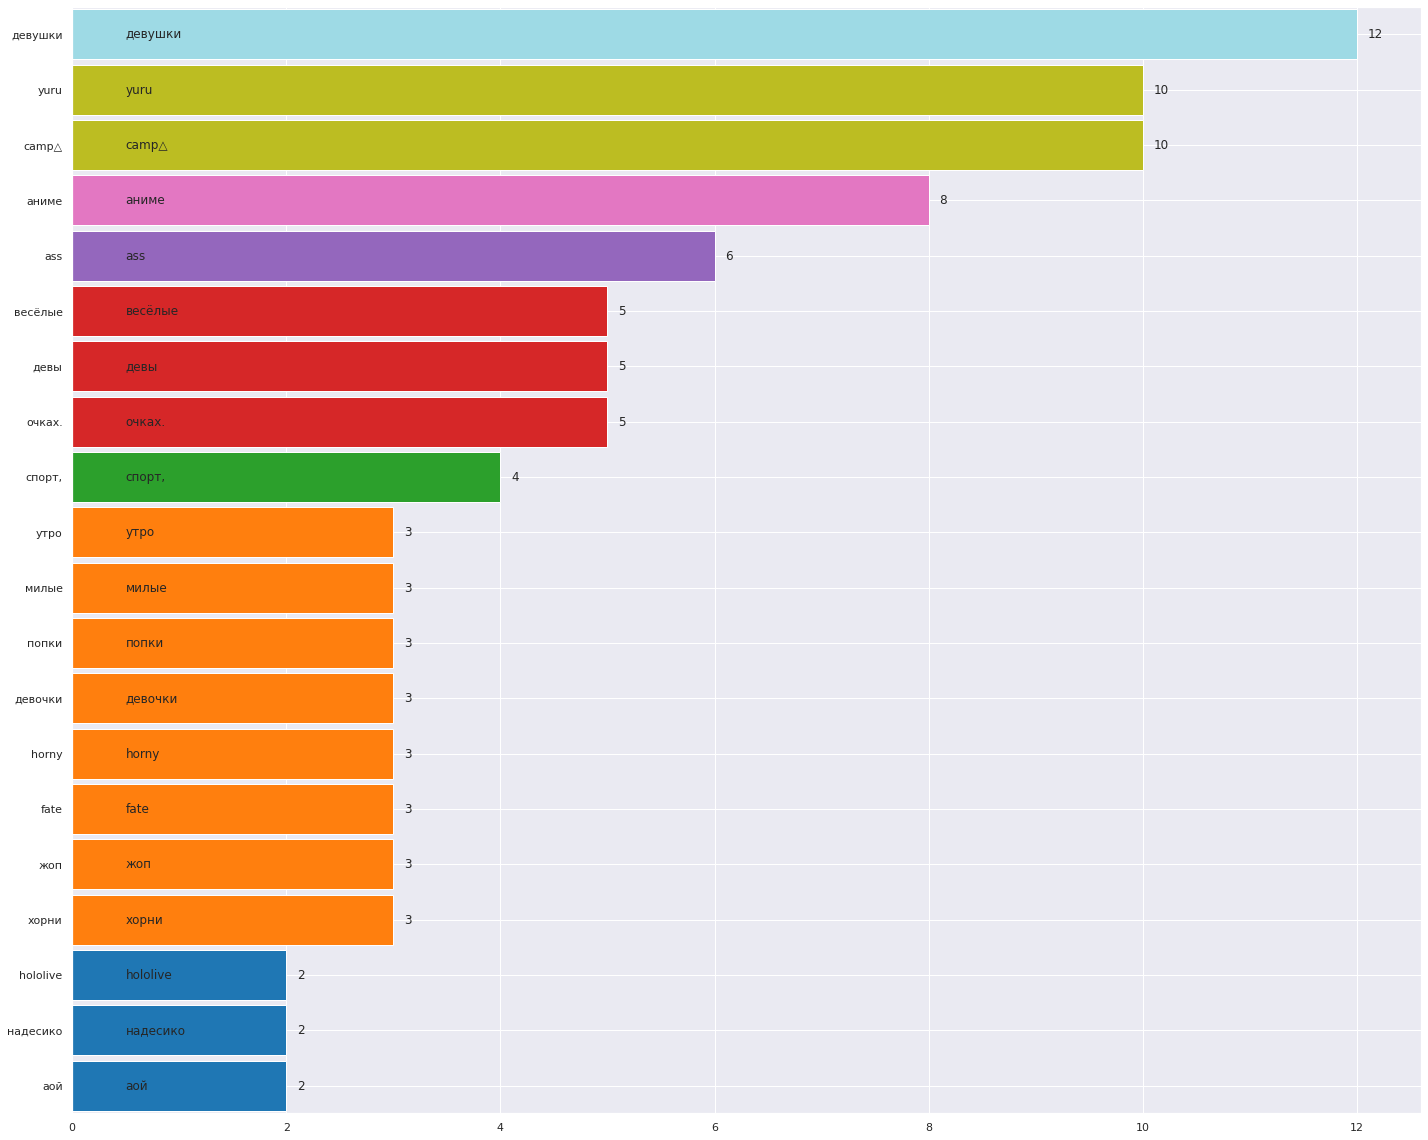

In [469]:
title_words = title_words.head(20)

labels = title_words.index[::-1]#.astype('str')
values = title_words[0][::-1]

my_cmap = plt.get_cmap("tab20") #cool_r
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=title_words.index[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 0.1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(0.5, i, '{}'.format(label), ha = 'left', va = 'center')
    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
# plt.xlabel('Количество комментариев', fontsize=16)
# plt.ylabel('ID публикации', fontsize=16)
# plt.title('Топ-20 Подборок по количеству комментариев', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/top_sets_titles.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [273]:
# result = Counter(" ".join(tmp['title'].values.tolist()).split(" ")).items()
# result

In [296]:
from collections import Counter

results = Counter()
tmp.title.str.lower().str.split().apply(results.update)

print(results)

Counter({'подборка': 81, '[nsfw]': 63, 'запись': 54, 'пользователя': 54, 'от': 45, 'артов': 38, 'и': 28, 'с': 26, 'арты': 22, 'в': 21, 'по': 18, 'из': 16, 'немного': 14, 'не': 14, 'девушки': 12, 'арт': 12, 'diego': 11, 'paw': 11, 'олег': 11, 'уходи': 11, 'для': 11, 'картинки': 10, 'yuru': 10, 'camp△': 10, '#nsfw': 9, 'подборочка': 9, 'на': 9, 'pack': 8, 'работ': 8, 'алексей': 8, 'кудрявцев': 8, 'desu': 8, 'appreciation': 8, 'post': 8, 'пост': 8, '—': 8, 'аниме': 8, 'сканов': 7, 'часть': 7, 'degoose': 7, '(арт)': 7, 'ass': 6, 'пак': 6, 'небольшая': 6, '#1': 6, 'nsfw': 6, 'random': 6, 'девы': 5, 'а': 5, 'доброе': 5, 'я': 5, 'весёлые': 5, 'очках.': 5, 'внутри': 5, 'сегодня': 5, '(nsfw)': 4, 'спорт,': 4, '-': 4, 'horny': 4, 'что': 4, 'гусь': 4, 'хмурый': 4, 'ещё': 4, 'кек': 4, 'журнальных': 4, 'megami': 4, '4': 4, 'for': 4, 'megumin': 4, '3': 4, 'тут': 4, 'у': 4, 'милые': 3, 'утренний': 3, 'жоп': 3, 'мемы': 3, 'попки': 3, ':3': 3, 'fate': 3, 'утро': 3, 'мне': 3, 'ты': 3, 'много': 3, '#3': 

In [290]:
set_words = tmp.title.apply(lambda x: str(x).lower().split(' ')[0])
set_words.value_counts().head(20)

подборка      60
[nsfw]        56
запись        54
немного       12
арт           11
девушки       11
арты           8
random         6
небольшая      6
внутри         5
desu           5
весёлые        5
не             4
подборочка     4
юри            3
в              3
_some:arts     3
милые          3
спорт,         3
вот            3
Name: title, dtype: int64

In [ ]:
asd = df.groupby(['type_of_post', 'author_name'], as_index=False).agg({'id': 'count'})
asd

In [ ]:
asd[asd.type_of_post == 'Ультра-Медиа-Логрид'].sort_values(by='id', ascending=False).head(20)

In [ ]:
df[(df.author_name == 'олег уходи') & (df.type_of_post == 'Лонгрид')]

In [473]:
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
6,2020-07-13 12:44:35,169901,https://dtf.ru/u/92674-ayan-myrzagali/169901-m...,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",5,6,155,True,27,Ayan Myrzagali,...,0,0,2,"[#music, #jpop, #mariyatakeuchi]",12,7,Monday,0,2020-07,Заметка
7,2020-07-14 20:10:03,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",42,4,1407,False,64,Виабу,...,0,0,1,[],20,7,Tuesday,0,2020-07,Заметка
8,2020-07-14 20:49:12,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",6,1,160,False,24,Виабу,...,0,0,1,[],20,7,Tuesday,0,2020-07,Заметка
9,2020-07-14 20:57:17,170958,https://dtf.ru/s/weaboo/170958,"{'id': 197370, 'url': 'https://dtf.ru/u/197370...",8,1,117,False,19,Виабу,...,0,0,1,[],20,7,Tuesday,0,2020-07,Заметка
14,2020-07-14 22:52:30,171065,https://dtf.ru/s/weaboo/171065,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",0,0,28,False,18,Виабу,...,0,0,2,[],22,7,Tuesday,0,2020-07,Заметка


In [483]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [475]:
subset_posts = df.resample('D').apply({'id':'count', 'type_of_post': 'count'})
subset_posts = subset_posts[subset_posts.index > '2020-07-14']
subset_posts = subset_posts[subset_posts.index < '2021-05-01']
subset_posts.head()

,id,type_of_post
date,,
2020-07-15,13,13
2020-07-16,11,11
2020-07-17,16,16
2020-07-18,11,11
2020-07-19,11,11


https://stackoverflow.com/questions/51034291/in-python-how-do-i-create-a-line-plot-based-on-groupby-of-two-categories-wit

https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot

https://stackoverflow.com/questions/50594613/how-to-plot-aggregated-by-date-pandas-dataframe

https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot/56652699

In [481]:
df = pd.read_pickle(PATH + 'Full_analysis/Analysed_weaboo_data_02_05.pkl')
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period,type_of_post
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1999,True,36,Офтоп,...,0,0,45,[#long],21,3,Monday,0,2018-03,Лонгрид
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,665,True,56,Алексей Фёдоров,...,0,0,17,[#anime],20,1,Sunday,1,2020-01,Статья
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,749,True,49,Алексей Фёдоров,...,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02,Подборка
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,238,True,41,Алексей Фёдоров,...,1,0,20,[#anime],18,2,Saturday,1,2020-02,Подборка
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,17,[],10,3,Monday,0,2020-03,Лонгрид


In [493]:
df.columns

Index(['id', 'url', 'author', 'comments_count', 'favorites_count',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'blocks',
       'repost', 'media_content_types', 'author_name', 'author_type',
       'author_avatar_url', 'symbols', 'words', 'images', 'videos', 'links',
       'audio', 'total_mediacontent', 'hashtags', 'hour', 'month', 'weekday',
       'is_weekend', 'period', 'type_of_post'],
      dtype='object')

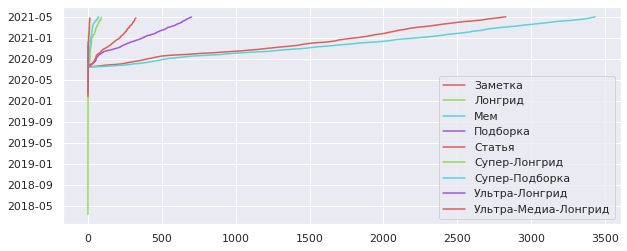

In [491]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df.groupby(['type_of_post']):
    ax.plot(grp.index, label=key)

ax.legend()
plt.show()

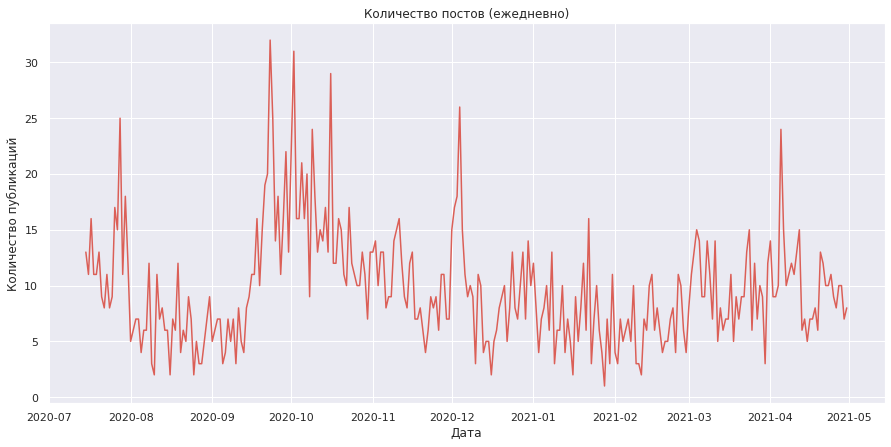

In [478]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=subset_posts, x=subset_posts.index, y=subset_posts.type_of_post)
plt.title('Количество постов (ежедневно)')
plt.ylabel('Количество публикаций')
plt.xlabel('Дата')
plt.grid(True)

In [ ]:
from manim import *

In [ ]:
%%manim MovingFrame [CLI options]

class MovingFrame(GraphScene):
    def __init__(self, **kwargs):
        GraphScene.__init__(
            self,
            x_min=-3.5,
            x_max=3.5,
            y_min=-5,
            y_max=5,
            graph_origin=ORIGIN,
            axes_color=BLUE,
            x_labeled_nums=range(-4, 4, 2), # x tickers
            y_labeled_nums=range(-5, 5, 2), # y tickers
            **kwargs
        )
    
    def construct(self):
        self.setup_axes(animate=False)

        # Draw graphs
        func_graph_cube = self.get_graph(lambda x: x**3, RED)
        func_graph_ncube = self.get_graph(lambda x: -x**3, GREEN)

        # Create labels
        graph_lab = self.get_graph_label(func_graph_cube, label="x^3")
        graph_lab2 = self.get_graph_label(func_graph_ncube, label="-x^3", x_val=-3)

        # Create a vertical line
        vert_line = self.get_vertical_line_to_graph(1.5, func_graph_cube, color=YELLOW)
        label_coord = self.input_to_graph_point(1.5, func_graph_cube)
        text = MathTex(r"x=1.5")
        text.next_to(label_coord)
       
        self.add(func_graph_cube, func_graph_ncube, graph_lab, graph_lab2, vert_line, text)
        self.wait()